<a href="https://colab.research.google.com/github/Sina-97/HAQNN-Ensemble_Learning/blob/main/HAQNN_Ensemble_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

In [ ]:
%cd /content

/content


In [ ]:
!git clone -b isca https://github.com/mit-han-lab/torchquantum.git
%cd torchquantum
!pip install --editable .
# !pip install qiskit_ibm_runtime==0.20
# !pip install -U qiskit-aer

Cloning into 'torchquantum'...
remote: Enumerating objects: 15554, done.
remote: Counting objects: 100% (2222/2222), done.
remote: Compressing objects: 100% (682/682), done.
remote: Total 15554 (delta 1745), reused 1767 (delta 1532), pack-reused 13332
Receiving objects: 100% (15554/15554), 100.22 MiB | 14.99 MiB/s, done.
Resolving deltas: 100% (8863/8863), done.
Updating files: 100% (223/223), done.
/content/torchquantum
Obtaining file:///content/torchquantum
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 16.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 38.6 MB/s eta 0:00:00
     ━━━━━

In [ ]:
#from qiskit import IBMQ

In [ ]:
!pip install tensorflow_model_optimization .
# !ls artifact
# !cp artifact/aerbackend.py ../../usr/local/lib/python3.7/dist-packages/qiskit/providers/aer/backends/ -r
!wget https://www.dropbox.com/s/pvoqeab2z2cazke/max-acc-valid.pt
# !pip install matplotlib==3.1.3
!pip install torchdiffeq
%matplotlib inline

Processing /content/torchquantum
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 5.3 MB/s eta 0:00:00
  Created wheel for torchquantum: filename=torchquantum-0.1.7-py3-none-any.whl size=127941 sha256=703e3f9d03b410385869707d83c5559e02f3210a85a39ea7e856c9f85a0dac07
  Stored in directory: /tmp/pip-ephem-wheel-cache-wbkqvt4b/wheels/28/d9/27/82c2925ba97060918bd35f9818cc7d29aeabcc32ae0971deea
Successfully built torchquantum
  Attempting uninstall: torchquantum
    Found existing installation: torchquantum 0.1.7
    Uninstalling torchquantum-0.1.7:
      Successfully uninstalled torchquantum-0.1.7
--2024-06-13 17:48:15--  https://www.dropbox.com/s/pvoqeab2z2cazke/max-acc-valid.pt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/uqnz

In [ ]:
!pip install opt_einsum

In [ ]:
# %cd %cd /content/torchquantum
import argparse
import os
import sys
import pdb
import numpy as np
import torch
import torch.backends.cudnn
import torch.cuda
import torch.nn
import torch.utils.data
import torchquantum as tq
import tqdm
import random

from torchpack.utils import io
# from torchpack import distributed as dist
from torchpack.environ import set_run_dir
from torchpack.utils.config import configs
from torchpack.utils.logging import logger
from torchquantum.datasets import MNIST, CIFAR10
import torch.optim as optim

from torchquantum.plugins import tq2qiskit, qiskit2tq
from torchquantum.utils import (build_module_from_op_list,
                                build_module_op_list,
                                get_v_c_reg_mapping,
                                get_p_c_reg_mapping,
                                get_p_v_reg_mapping,
                                get_cared_configs)
from torchquantum.super_utils import get_named_sample_arch

# from torch.utils.tensorboard import SummaryWriter

In [ ]:
import torch
import torchquantum as tq
import torchquantum.functional as tqf
import torch.nn.functional as F

from torchpack.utils.logging import logger
from torchquantum.encoding import encoder_op_list_name_dict
from torchquantum.super_layers import super_layer_name_dict



# Function and model

In [ ]:
from torchquantum.plugins import (
    tq2qiskit_measurement,
    qiskit_assemble_circs,
    op_history2qiskit,
    op_history2qiskit_expand_params,
)

class SuperQFCModel0(tq.QuantumModule):
    def __init__(self, arch):
        super().__init__()
        self.arch = arch
        self.n_wires = arch['n_wires']
        # self.norm = torch.nn.BatchNorm1d(self.n_wires)

        # self.q_device = tq.QuantumDevice(n_wires=self.n_wires)
        self.encoder = tq.GeneralEncoder(
            encoder_op_list_name_dict[arch['encoder_op_list_name']]
        )
        self.q_layer = super_layer_name_dict[arch['q_layer_name']](arch)
        self.measure = tq.MeasureAll(tq.PauliZ)
        self.sample_arch = None

    def set_sample_arch(self, sample_arch):
        self.sample_arch = sample_arch
        self.q_layer.set_sample_arch(sample_arch)

    def count_sample_params(self):
        return self.q_layer.count_sample_params()

    def forward(self, x, verbose=False, use_qiskit=False):
        bsz = x.shape[0]
        qdev = tq.QuantumDevice(n_wires=self.n_wires, bsz=bsz, record_op=True, device=x.device)
        # self.q_device.reset_states(bsz=bsz)

        if getattr(self.arch, 'down_sample_kernel_size', None) is not None:
            x = F.avg_pool2d(x, self.arch['down_sample_kernel_size'])

        x = x.view(bsz, -1)

        if use_qiskit:
            # use qiskit to process the circuit
            # create the qiskit circuit for encoder
            self.encoder(qdev, x)
            op_history_parameterized = qdev.op_history
            qdev.reset_op_history()
            encoder_circs = op_history2qiskit_expand_params(self.n_wires, op_history_parameterized, bsz=bsz)

            # create the qiskit circuit for trainable quantum layers
            self.q_layer(qdev)
            op_history_fixed = qdev.op_history
            qdev.reset_op_history()
            q_layer_circ = op_history2qiskit(self.n_wires, op_history_fixed)

            # create the qiskit circuit for measurement
            measurement_circ = tq2qiskit_measurement(qdev, self.measure)

            # assemble the encoder, trainable quantum layers, and measurement circuits
            assembled_circs = qiskit_assemble_circs(
                encoder_circs, q_layer_circ, measurement_circ
            )

            # call the qiskit processor to process the circuit
            x0 = self.qiskit_processor.process_ready_circs(qdev, assembled_circs).to(  # type: ignore
                x.device
            )
            x = x0

            # x = self.qiskit_processor.process_parameterized(
                # self.q_device, self.encoder, self.q_layer, self.measure, x)
        else:
            self.encoder(qdev, x)
            self.q_layer(qdev)
            x = self.measure(qdev)

        if verbose:
            logger.info(f"[use_qiskit]={use_qiskit}, expectation:\n {x.data}")

        if getattr(self.arch, 'output_len', None) is not None:
            x = x.reshape(bsz, -1, self.arch.output_len).sum(-1)

        if x.dim() > 2:
            x = x.squeeze()

        # x=self.norm(x)
        x = F.log_softmax(x, dim=1)
        return x

    @property
    def arch_space(self):
        space = []
        for layer in self.q_layer.super_layers_all:
            space.append(layer.arch_space)
        # for the number of sampled blocks
        space.append(list(range(self.q_layer.n_front_share_blocks,
                                self.q_layer.n_blocks + 1)))
        return space


# Config

In [ ]:
config_str = '''model:
  arch:
    n_wires: 4
    encoder_op_list_name: 4x4_ryzxy
    n_blocks: 3
    n_layers_per_block: 2
    q_layer_name: u3cu3_s0
    down_sample_kernel_size: 6
    n_front_share_blocks: 1
    n_front_share_wires: 1
    n_front_share_ops: 1
  sampler:
    strategy:
      name: plain
  transpile_before_run: False
  load_op_list: False

dataset:
  name: mnist
  input_name: image
  target_name: digit

optimizer:
  name: adam
  lr: 5e-2
  weight_decay: 1e-4
  lambda_lr: 1e-2

run:
  n_epochs: 40
  bsz: 128
  workers_per_gpu: 2
  device: gpu

debug:
  pdb: False
  set_seed: True
  seed: 42

callbacks:
  - callback: 'InferenceRunner'
    split: 'valid'
    subcallbacks:
      - metrics: 'CategoricalAccuracy'
        name: 'acc/valid'
      - metrics: 'NLLError'
        name: 'loss/valid'
  - callback: 'InferenceRunner'
    split: 'test'
    subcallbacks:
      - metrics: 'CategoricalAccuracy'
        name: 'acc/test'
      - metrics: 'NLLError'
        name: 'loss/test'
  - callback: 'MaxSaver'
    name: 'acc/valid'
  - callback: 'Saver'
    max_to_keep: 10

qiskit:
  use_qiskit: False
  use_real_qc: False
  backend_name: null
  noise_model_name: null
  basis_gates_name: null
  n_shots: 8192
  initial_layout: null
  seed_transpiler: 42
  seed_simulator: 42
  optimization_level: 0
  est_success_rate: False
  max_jobs: 1


es:
  random_search: False
  population_size: 100
  parent_size: 20
  mutation_size: 40
  mutation_prob: 0.5
  crossover_size: 40
  n_iterations: 5
  est_success_rate: False
  score_mode: loss_succ
  gene_mask: null
  eval:
    use_noise_model: False
    use_real_qc: False
    bsz: qiskit_max
    n_test_samples: 150


prune:
  target_pruning_amount : 0.5
  init_pruning_amount : 0.1
  start_epoch : 0
  end_epoch : 30

'''
f = open("configs.yml", "w")
f.write(config_str)
f.close()

In [ ]:
configs.load('configs.yml')
if configs.debug.set_seed:
    torch.manual_seed(configs.debug.seed)
    np.random.seed(configs.debug.seed)

# LeNet5 function

In [ ]:
import torch
import torch.nn as nn
from tensorflow import keras
from tensorflow.keras import layers, models
import torch.optim as optim
import torch.nn.functional as F


from tensorflow.keras import layers


# LeNet5 Model function
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(16*7*7, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        # print(x.shape)
        x = x.view(-1, 16*7*7)
        # print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# for data in dataflow['test']:
#     inputs = data['image'].to(device)
#     targets = data['digit'].to(device)
#     outputs = encoder1_lenet(inputs)
#     outputs = maxpool1(outputs)
#     outputs = encoder2_lenet(outputs)
#     outputs = maxpool2(outputs)
#     print(outputs.shape)
#     break




# Train Function

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import time

def train_step(dataflow, model, device, optimizer,cnn_model=None,weight_decay=0.0001):
    for feed_dict in dataflow["train"]:
        size=feed_dict["image"].shape[0]

        inputs = feed_dict["image"].to(device)
        targets = feed_dict["digit"].to(device)
        # outputs_ann = cnn_model(inputs)
        # outputs = model(outputs_ann)
        outputs = model(inputs)

        loss=F.nll_loss(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"loss: {loss.item()}", end="\r")

def valid_test(dataflow, split, model, device,cnn_model=None, qiskit=False):
    target_all = []
    output_all = []
    with torch.no_grad():

        for feed_dict in dataflow[split]:
            inputs = feed_dict["image"].to(device)
            targets = feed_dict["digit"].to(device)

            # outputs_ann = cnn_model(inputs)
            # outputs = model(outputs_ann, use_qiskit=qiskit)
            outputs = model(inputs, use_qiskit=qiskit)
            target_all.append(targets)
            output_all.append(outputs)
        target_all = torch.cat(target_all, dim=0)
        output_all = torch.cat(output_all, dim=0)

    _, indices = output_all.topk(1, dim=1)
    masks = indices.eq(target_all.view(-1, 1).expand_as(indices))
    size = target_all.shape[0]
    corrects = masks.sum().item()
    accuracy = corrects / size
    loss = F.nll_loss(output_all, target_all).item()

    print(f"{split} set accuracy: {accuracy}")
    print(f"{split} set loss: {loss}")

    return accuracy





# Checking the Effect of Post-Measurement Normalization

In [ ]:
# Initiallization
import random
device = torch.device('cuda')
if isinstance(configs.optimizer.lr, str):
    configs.optimizer.lr = eval(configs.optimizer.lr)
digits_random = random.sample(range(10), 4)
print(digits_random)
dataset = MNIST(
    root='./mnist_data',
    train_valid_split_ratio=[0.9, 0.1],
    digits_of_interest=digits_random,
    # digits_of_interest=[1,2,3,4,5,6,7,8,9,0],
    n_test_samples=300,
    n_train_samples=4000,
    n_valid_samples=2000,
    fashion=True
)

# dataset = CIFAR10(
#     root='./cifar_data',
#     train_valid_split_ratio=[0.9, 0.1],
#     # digits_of_interest=[1,2,3,4],
#     digits_of_interest=[0,1,2,3,4,5,6,7,8,9],
#     n_test_samples=100,
#     n_valid_samples=1000
#     # fashion=True
# )


dataflow = dict()
for split in dataset:
    sampler = torch.utils.data.RandomSampler(dataset[split])
    dataflow[split] = torch.utils.data.DataLoader(
        dataset[split],
        batch_size=configs.run.bsz,
        sampler=sampler,
        num_workers=configs.run.workers_per_gpu,
        pin_memory=True)

from torchquantum.plugins import QiskitProcessor
from qiskit import IBMQ
IBMQ.save_account('b45e8d28e72f73d5a608f7a019b299b75a43080a7fc7ac1c222715e9816b0ab74c41156995f37ca4c84f270863b11d3cc5de9be8a434c3d5da7cbaba21ab5d7a', overwrite=True)
processor_real_qc = QiskitProcessor(use_real_qc=False, noise_model_name = 'ibm_kyoto', backend_name='ibm_kyoto',noise_model="ibm_kyoto")
processor_real_qc.set_layout(digits_random) # default layout: virtual qubit 0 for physical qubit 0, ..., virtual qubit 3 for physical qubit 3



[2024-06-13 18:37:58.376] Only use the front 4000 images as TRAIN set.


[9, 3, 0, 6]


[2024-06-13 18:37:58.520] Only use the front 2000 images as VALID set.
[2024-06-13 18:37:58.546] Only use the front 300 images as TEST set.
ibmqfactory.load_account:WARNING:2024-06-13 18:37:58,848: Credentials are already in use. The existing account in the session will be replaced.


In [ ]:
## Model with No Normalization
class SuperQFCModel0(tq.QuantumModule):
    def __init__(self, arch):
        super().__init__()
        self.arch = arch
        self.n_wires = arch['n_wires']
        # self.norm = torch.nn.BatchNorm1d(self.n_wires)

        # self.q_device = tq.QuantumDevice(n_wires=self.n_wires)
        self.encoder = tq.GeneralEncoder(
            encoder_op_list_name_dict[arch['encoder_op_list_name']]
        )
        self.q_layer = super_layer_name_dict[arch['q_layer_name']](arch)
        self.measure = tq.MeasureAll(tq.PauliZ)
        self.sample_arch = None

    def set_sample_arch(self, sample_arch):
        self.sample_arch = sample_arch
        self.q_layer.set_sample_arch(sample_arch)

    def count_sample_params(self):
        return self.q_layer.count_sample_params()

    def forward(self, x, verbose=False, use_qiskit=False):
        bsz = x.shape[0]
        qdev = tq.QuantumDevice(n_wires=self.n_wires, bsz=bsz, record_op=True, device=x.device)
        # self.q_device.reset_states(bsz=bsz)

        if getattr(self.arch, 'down_sample_kernel_size', None) is not None:
            x = F.avg_pool2d(x, self.arch['down_sample_kernel_size'])

        x = x.view(bsz, -1)

        if use_qiskit:
            # use qiskit to process the circuit
            # create the qiskit circuit for encoder
            self.encoder(qdev, x)
            op_history_parameterized = qdev.op_history
            qdev.reset_op_history()
            encoder_circs = op_history2qiskit_expand_params(self.n_wires, op_history_parameterized, bsz=bsz)

            # create the qiskit circuit for trainable quantum layers
            self.q_layer(qdev)
            op_history_fixed = qdev.op_history
            qdev.reset_op_history()
            q_layer_circ = op_history2qiskit(self.n_wires, op_history_fixed)

            # create the qiskit circuit for measurement
            measurement_circ = tq2qiskit_measurement(qdev, self.measure)

            # assemble the encoder, trainable quantum layers, and measurement circuits
            assembled_circs = qiskit_assemble_circs(
                encoder_circs, q_layer_circ, measurement_circ
            )

            # call the qiskit processor to process the circuit
            x0 = self.qiskit_processor.process_ready_circs(qdev, assembled_circs).to(  # type: ignore
                x.device
            )
            x = x0

            # x = self.qiskit_processor.process_parameterized(
                # self.q_device, self.encoder, self.q_layer, self.measure, x)
        else:
            self.encoder(qdev, x)
            self.q_layer(qdev)
            x = self.measure(qdev)

        if verbose:
            logger.info(f"[use_qiskit]={use_qiskit}, expectation:\n {x.data}")

        if getattr(self.arch, 'output_len', None) is not None:
            x = x.reshape(bsz, -1, self.arch.output_len).sum(-1)

        if x.dim() > 2:
            x = x.squeeze()

        # x=self.norm(x)
        x = F.log_softmax(x, dim=1)
        return x

    @property
    def arch_space(self):
        space = []
        for layer in self.q_layer.super_layers_all:
            space.append(layer.arch_space)
        # for the number of sampled blocks
        space.append(list(range(self.q_layer.n_front_share_blocks,
                                self.q_layer.n_blocks + 1)))
        return space

In [ ]:
## Train with no Post-Measurement Normalization
model = SuperQFCModel0(configs.model.arch)
state_dict = io.load('max-acc-valid.pt', map_location='cpu')
model.load_state_dict(state_dict['model'], strict=False)
model.to(device)
model.set_sample_arch([4,4,4,4,4,4,3])
model.set_qiskit_processor(processor_real_qc)

from torch.optim.lr_scheduler import CosineAnnealingLR
n_epochs = 5
acc_list=[]
optimizer1 = optim.Adam(model.parameters(), lr=2e-2, weight_decay=1e-4)
scheduler1 = CosineAnnealingLR(optimizer1, T_max=n_epochs)

for epoch in range(1, n_epochs + 1):

            print(f"Epoch {epoch}:")
            train_step(dataflow, model, device, optimizer1)
            print(optimizer1.param_groups[0]["lr"])

            acc=valid_test(dataflow, "valid", model, device)
            acc_list.append(acc)

            scheduler1.step()

Epoch 1:
0.02
valid set accuracy: 0.645
valid set loss: 1.1392229795455933
Epoch 2:
0.018090169943749474
valid set accuracy: 0.689
valid set loss: 1.0731157064437866
Epoch 3:
0.013090169943749473
valid set accuracy: 0.6805
valid set loss: 1.048643946647644
Epoch 4:
0.0069098300562505256
valid set accuracy: 0.7045
valid set loss: 1.0374386310577393
Epoch 5:
0.0019098300562505263
valid set accuracy: 0.7065
valid set loss: 1.0351612567901611


In [ ]:
## Adding Post-Measurement Normalization

class SuperQFCModel0(tq.QuantumModule):
    def __init__(self, arch):
        super().__init__()
        self.arch = arch
        self.n_wires = arch['n_wires']
        self.norm = torch.nn.BatchNorm1d(self.n_wires)

        # self.q_device = tq.QuantumDevice(n_wires=self.n_wires)
        self.encoder = tq.GeneralEncoder(
            encoder_op_list_name_dict[arch['encoder_op_list_name']]
        )
        self.q_layer = super_layer_name_dict[arch['q_layer_name']](arch)
        self.measure = tq.MeasureAll(tq.PauliZ)
        self.sample_arch = None

    def set_sample_arch(self, sample_arch):
        self.sample_arch = sample_arch
        self.q_layer.set_sample_arch(sample_arch)

    def count_sample_params(self):
        return self.q_layer.count_sample_params()

    def forward(self, x, verbose=False, use_qiskit=False):
        bsz = x.shape[0]
        qdev = tq.QuantumDevice(n_wires=self.n_wires, bsz=bsz, record_op=True, device=x.device)
        # self.q_device.reset_states(bsz=bsz)

        if getattr(self.arch, 'down_sample_kernel_size', None) is not None:
            x = F.avg_pool2d(x, self.arch['down_sample_kernel_size'])

        x = x.view(bsz, -1)

        if use_qiskit:
            # use qiskit to process the circuit
            # create the qiskit circuit for encoder
            self.encoder(qdev, x)
            op_history_parameterized = qdev.op_history
            qdev.reset_op_history()
            encoder_circs = op_history2qiskit_expand_params(self.n_wires, op_history_parameterized, bsz=bsz)

            # create the qiskit circuit for trainable quantum layers
            self.q_layer(qdev)
            op_history_fixed = qdev.op_history
            qdev.reset_op_history()
            q_layer_circ = op_history2qiskit(self.n_wires, op_history_fixed)

            # create the qiskit circuit for measurement
            measurement_circ = tq2qiskit_measurement(qdev, self.measure)

            # assemble the encoder, trainable quantum layers, and measurement circuits
            assembled_circs = qiskit_assemble_circs(
                encoder_circs, q_layer_circ, measurement_circ
            )

            # call the qiskit processor to process the circuit
            x0 = self.qiskit_processor.process_ready_circs(qdev, assembled_circs).to(  # type: ignore
                x.device
            )
            x = x0

            # x = self.qiskit_processor.process_parameterized(
                # self.q_device, self.encoder, self.q_layer, self.measure, x)
        else:
            self.encoder(qdev, x)
            self.q_layer(qdev)
            x = self.measure(qdev)

        if verbose:
            logger.info(f"[use_qiskit]={use_qiskit}, expectation:\n {x.data}")

        if getattr(self.arch, 'output_len', None) is not None:
            x = x.reshape(bsz, -1, self.arch.output_len).sum(-1)

        if x.dim() > 2:
            x = x.squeeze()

        x=self.norm(x)
        x = F.log_softmax(x, dim=1)
        return x

    @property
    def arch_space(self):
        space = []
        for layer in self.q_layer.super_layers_all:
            space.append(layer.arch_space)
        # for the number of sampled blocks
        space.append(list(range(self.q_layer.n_front_share_blocks,
                                self.q_layer.n_blocks + 1)))
        return space

In [ ]:
## Train with Post-Measurement Normalization

model_post = SuperQFCModel0(configs.model.arch)
state_dict = io.load('max-acc-valid.pt', map_location='cpu')
model_post.load_state_dict(state_dict['model'], strict=False)
model_post.to(device)
model_post.set_sample_arch([4,4,4,4,4,4,3])

model_post.set_qiskit_processor(processor_real_qc)

from torch.optim.lr_scheduler import CosineAnnealingLR
n_epochs = 5
acc_list2=[]
optimizer1 = optim.Adam(model_post.parameters(), lr=2e-2, weight_decay=1e-4)
scheduler1 = CosineAnnealingLR(optimizer1, T_max=n_epochs)

for epoch in range(1, n_epochs + 1):

            print(f"Epoch {epoch}:")
            train_step(dataflow, model_post, device, optimizer1)
            print(optimizer1.param_groups[0]["lr"])

            acc=valid_test(dataflow, "valid", model_post, device)
            acc_list2.append(acc)


Epoch 1:
0.02
test set accuracy: 0.66
test set loss: 0.9422234296798706
Epoch 2:
0.02
test set accuracy: 0.7333333333333333
test set loss: 0.7850266695022583
Epoch 3:
0.02
test set accuracy: 0.75
test set loss: 0.7256485223770142
Epoch 4:
0.02
test set accuracy: 0.75
test set loss: 0.6871516704559326
Epoch 5:
0.02
test set accuracy: 0.78
test set loss: 0.6734667420387268


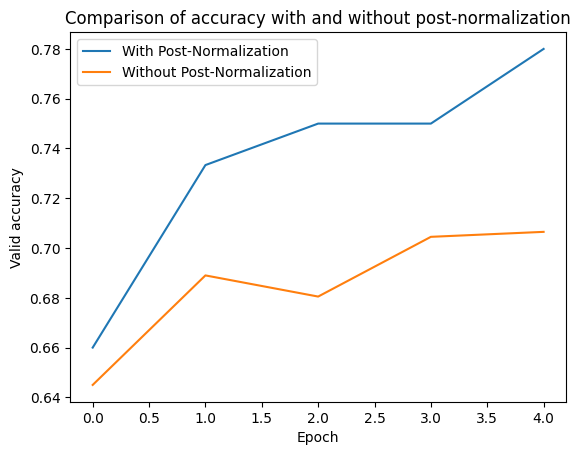

In [ ]:
import matplotlib.pyplot as plt
plt.plot(acc_list2, label="With Post-Normalization")
plt.plot(acc_list, label="Without Post-Normalization")
plt.title("Comparison of accuracy with and without post-normalization")
plt.ylabel("Valid accuracy")
plt.xlabel("Epoch")
plt.legend()

# Random Search Function

In [ ]:
def log_acc(output_all, target_all, k=1):
    _, indices = output_all.topk(k, dim=1)
    masks = indices.eq(target_all.view(-1, 1).expand_as(indices))
    size = target_all.shape[0]
    corrects = masks.sum().item()
    accuracy = corrects / size
    loss = F.nll_loss(output_all, target_all).item()
    logger.info(f"Accuracy: {accuracy}")
    logger.info(f"Loss: {loss}")
    return accuracy

def evaluate_gene(gene=None, use_qiskit=False, model=model):
    if gene is not None:
        model.set_sample_arch(gene)
    with torch.no_grad():
        target_all = None
        output_all = None
        for feed_dict in tqdm.tqdm(dataflow['test']):
            if configs.run.device == 'gpu':
                # pdb.set_trace()
                inputs = feed_dict[configs.dataset.input_name].cuda(non_blocking=True)
                targets = feed_dict[configs.dataset.target_name].cuda(non_blocking=True)
            else:
                inputs = feed_dict[configs.dataset.input_name]
                targets = feed_dict[configs.dataset.target_name]
            outputs = model(inputs, use_qiskit=use_qiskit)
            if target_all is None:
                target_all = targets
                output_all = outputs
            else:
                target_all = torch.cat([target_all, targets], dim=0)
                output_all = torch.cat([output_all, outputs], dim=0)
        accuracy = log_acc(output_all, target_all)
    return accuracy

class RandomSearcher:
    def __init__(self, gene_choice, accuracy_predictor,model):
        self.gene_choice = gene_choice
        self.gene_len = len(self.gene_choice)
        self.accuracy_predictor = accuracy_predictor
        self.model=model

    def random_sample(self, sample_num):
        # randomly sample genes
        population = []
        i = 0
        while i < sample_num:
            samp_gene = []
            for k in range(self.gene_len):
                samp_gene.append(random.choices(self.gene_choice[k])[0])
            population.append(samp_gene)
            i += 1

        return population

    def run_search(self, n_subcircuits=100):
        # sample subcircuits
        self.population = self.random_sample(n_subcircuits)
        # predict the accuracy of subnets
        accs = []
        for gene in self.population:
          accs.append(self.accuracy_predictor(gene=gene, use_qiskit=True, model=self.model))


        # get the index of the best subnet
        accs = np.array(accs)
        best_idx = accs.argmax()

        # return the best subnet
        return accs[best_idx], self.population[best_idx]


In [ ]:
# agent = RandomSearcher(model.arch_space, evaluate_gene)

# # get the accuracy and gene of the best subcircuit
# acc, gene = agent.run_search(3)

# print(gene)
# print(acc)

Circuit depth: 6
Gate counts: OrderedDict([('u3', 18), ('cu3', 4)])
Architecture:


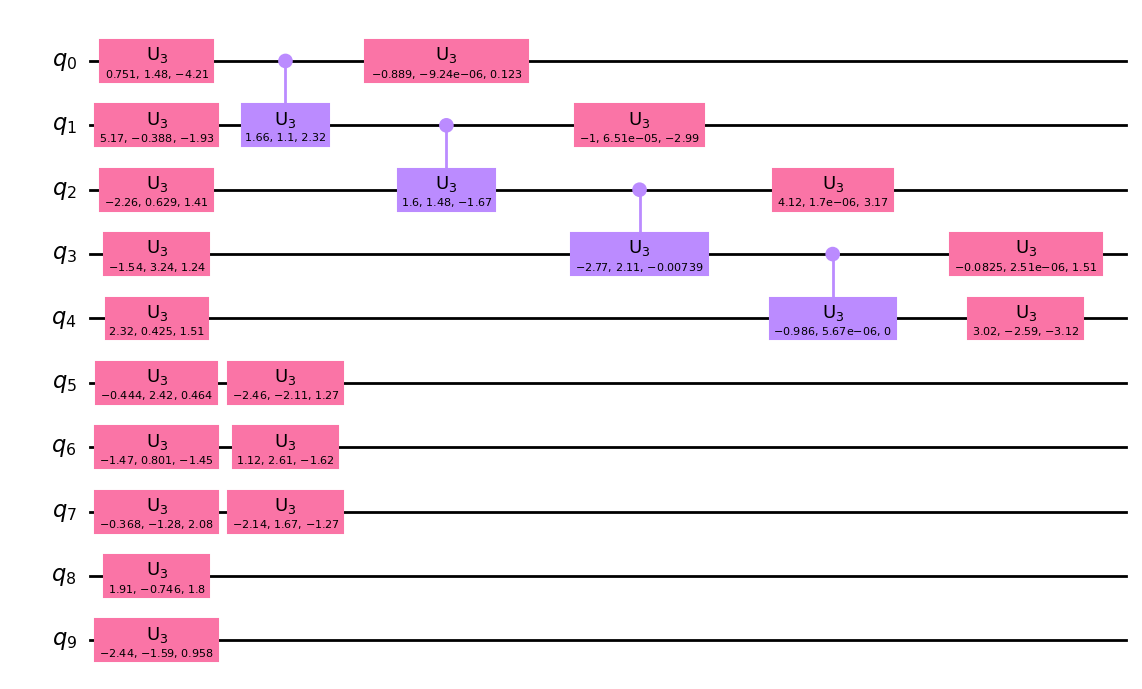

In [ ]:
# model.set_sample_arch(gene)
# circ = tq2qiskit(tq.QuantumDevice(n_wires=model.n_wires), model.q_layer)
# print("Circuit depth: {0}".format(circ.depth()))
# print("Gate counts: {0}".format(circ.count_ops()))
# print("Architecture:")
# circ.draw('mpl')

# Pruning Function

In [ ]:
import torch.nn as nn
import torch.nn.utils.prune
from torchquantum.prune_utils import (PhaseL1UnstructuredPruningMethod,
                                      ThresholdScheduler)
from torchpack.train import Trainer
from torchpack.utils.typing import Optimizer, Scheduler
from torchpack.callbacks.writers import TFEventWriter
from typing import Any, Callable, Dict

class PruningTrainer(Trainer):
    """
    Perform pruning-aware training
    """
    def __init__(self, *, model: nn.Module, criterion: Callable,
                 optimizer: Optimizer, scheduler: Scheduler,cnn_model=None) -> None:
        self.model = model
        self.legalized_model = None
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.solution = None
        self.score = None
        self.cnn_model=cnn_model

        self._parameters_to_prune = None
        self._target_pruning_amount = None
        self._init_pruning_amount = None
        self.prune_amount_scheduler = None
        self.prune_amount = None

        self.init_pruning()

    @staticmethod
    def extract_prunable_parameters(model: nn.Module) -> list:
        _parameters_to_prune = [
            (module, "params")
            for _, module in model.named_modules() if isinstance(module,
                                                                 tq.Operator)
            and module.params is not None]
        return _parameters_to_prune

    def init_pruning(self) -> None:
        """
        Initialize pruning procedure
        """
        self._parameters_to_prune = self.extract_prunable_parameters(
            self.model)
        self._target_pruning_amount = configs.prune.target_pruning_amount
        self._init_pruning_amount = configs.prune.init_pruning_amount
        self.prune_amount_scheduler = ThresholdScheduler(
            configs.prune.start_epoch, configs.prune.end_epoch,
            self._init_pruning_amount,
            self._target_pruning_amount)
        self.prune_amount = self._init_pruning_amount

    def _remove_pruning(self):
        for module, name in self._parameters_to_prune:
            nn.utils.prune.remove(module, name)

    def _prune_model(self, prune_amount) -> None:
        """
        Perform global threshold/percentage pruning on the quantum model.
        This function just performs pruning re-parametrization, i.e.,
        record weight_orig and generate weight_mask
        """
        # first clear current pruning container, since we do not want cascaded
        # pruning methods
        # remove operation will make pruning permanent
        if self.epoch_num > 1:
            self._remove_pruning()
        # perform global phase pruning based on the given pruning amount
        nn.utils.prune.global_unstructured(
            self._parameters_to_prune,
            pruning_method=PhaseL1UnstructuredPruningMethod,
            amount=prune_amount,
        )
        self.summary.add_scalar('prune_amount', prune_amount)

    def _before_epoch(self) -> None:
        self.model.train()

    def run_step(self, feed_dict: Dict[str, Any], legalize=False) -> Dict[str, Any]:
        output_dict = self._run_step(feed_dict, legalize=legalize)
        return output_dict

    def _run_step(self, feed_dict: Dict[str, Any], legalize=False) -> Dict[str, Any]:

        if configs.run.device == 'gpu':
            inputs = feed_dict[configs.dataset.input_name].cuda(
                non_blocking=True)
            # inputs=self.cnn_model(inputs)
            targets = feed_dict[configs.dataset.target_name].cuda(
                non_blocking=True)
        else:
            inputs = feed_dict[configs.dataset.input_name]
            # inputs=self.cnn_model(inputs)
            targets = feed_dict[configs.dataset.target_name]
        if legalize:
            outputs = self.legalized_model(inputs)
        else:
            outputs = self.model(inputs)
        loss = self.criterion(outputs, targets)
        nll_loss = loss.item()
        unitary_loss = 0

        if loss.requires_grad:
            for k, group in enumerate(self.optimizer.param_groups):
                self.summary.add_scalar(f'lr/lr_group{k}', group['lr'])

            self.summary.add_scalar('loss', loss.item())
            self.summary.add_scalar('nll_loss', nll_loss)
            if getattr(self.model, 'sample_arch', None) is not None:
                for writer in self.summary.writers:
                    if isinstance(writer, TFEventWriter):
                        writer.writer.add_text(
                            'sample_arch', str(self.model.sample_arch),
                            self.global_step)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        return {'outputs': outputs, 'targets': targets}

    def _after_epoch(self) -> None:
        self.model.eval()
        self.scheduler.step()
        # update pruning amount using the scheduler
        self.prune_amount = self.prune_amount_scheduler.step()
        # prune the model
        self._prune_model(self.prune_amount)
        # commit pruned parameters after training
        if self.epoch_num == self.num_epochs:
            self._remove_pruning()

    def _after_step(self, output_dict) -> None:
        pass

    def _state_dict(self) -> Dict[str, Any]:
        state_dict = dict()
        # need to store model arch because of randomness of random layers
        state_dict['model_arch'] = self.model
        state_dict['model'] = self.model.state_dict()
        state_dict['optimizer'] = self.optimizer.state_dict()
        state_dict['scheduler'] = self.scheduler.state_dict()
        if getattr(self.model, 'sample_arch', None) is not None:
            state_dict['sample_arch'] = self.model.sample_arch
        try:
            state_dict['q_layer_op_list'] = build_module_op_list(
                self.model.q_layer)
            state_dict['encoder_func_list'] = self.model.encoder.func_list
        except AttributeError:
            logger.warning(f"No q_layer_op_list or encoder_func_list found, "
                           f"will not save them")

        if self.solution is not None:
            state_dict['solution'] = self.solution
            state_dict['score'] = self.score

        try:
            state_dict['v_c_reg_mapping'] = self.model.measure.v_c_reg_mapping
        except AttributeError:
            logger.warning(f"No v_c_reg_mapping found, will not save it.")
        return state_dict

    def _load_state_dict(self, state_dict: Dict[str, Any]) -> None:
        # self.model.load_state_dict(state_dict['model'])
        self.optimizer.load_state_dict(state_dict['optimizer'])
        self.scheduler.load_state_dict(state_dict['scheduler'])

In [ ]:
from torchpack.callbacks import (InferenceRunner, MaxSaver, Saver, CategoricalAccuracy)
from examples.gradient_pruning.callbacks import NLLError

def get_subcallbacks(config):
    subcallbacks = []
    for subcallback in config:
        if subcallback['metrics'] == 'CategoricalAccuracy':
            subcallbacks.append(
                CategoricalAccuracy(name=subcallback['name'])
            )
        elif subcallback['metrics'] == 'NLLError':
            subcallbacks.append(
                NLLError(name=subcallback['name'])
            )
        else:
            raise NotImplementedError(subcallback['metrics'])
    return subcallbacks


def make_callbacks(dataflow):
    callbacks = []
    for config in configs['callbacks']:
        if config['callback'] == 'InferenceRunner':
            callback = InferenceRunner(
                dataflow=dataflow[config['split']],
                callbacks=get_subcallbacks(config['subcallbacks'])
            )
        elif config['callback'] == 'Saver':
            callback = Saver(max_to_keep=config['max_to_keep'])
        elif config['callback'] == 'MaxSaver':
            callback = MaxSaver(config['name'])
        else:
            raise NotImplementedError(config['callback'])
        callbacks.append(callback)

    return callbacks

# Train encoder for LeNet5

In [ ]:

# model_lenet=LeNet5()
# model_lenet.to(device)


# criterion=nn.CrossEntropyLoss()
# optimizer=optim.Adam(model_lenet.parameters(), lr=0.001)

# for epoch in range(4):
#     for data in dataflow['train']:
#         inputs = data['image'].to(device)
#         targets = data['digit'].to(device)
#         optimizer.zero_grad()
#         outputs = model_lenet(inputs)
#         loss = criterion(outputs, targets)
#         loss.backward()
#         optimizer.step()
#     print(f'Epoch {epoch+1}/{1}, Loss: {loss.item()}')


# for data in dataflow['test']:
#     inputs = data['image'].to(device)
#     targets = data['digit'].to(device)
#     outputs = model_lenet(inputs)
#     log_acc(outputs, targets)
#     break


# encoder1_lenet=model_lenet.conv1
# encoder2_lenet=model_lenet.conv2
# encoder1_lenet.to(device)
# encoder2_lenet.to(device)
# maxpool1=nn.MaxPool2d(kernel_size=2, stride=2)
# maxpool2=nn.MaxPool2d(kernel_size=2, stride=2)

# model_encoder_lenet=nn.Sequential(
#     encoder1_lenet,
#     maxpool1,
#     encoder2_lenet,
#     maxpool2
# )

Epoch 1/1, Loss: 1.1232621669769287
Epoch 2/1, Loss: 0.8144325613975525
Epoch 3/1, Loss: 0.6005544662475586
Epoch 4/1, Loss: 0.5525217056274414
Epoch 5/1, Loss: 0.36848506331443787


[2024-04-28 19:54:51.028] Accuracy: 0.75
[2024-04-28 19:54:51.029] Loss: -8.340513229370117


In [ ]:
torch.cuda.is_available()

True

# Train and Pruning QNN

In [ ]:
from torchquantum.plugins import QiskitProcessor
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten

from qiskit import IBMQ
IBMQ.save_account('b45e8d28e72f73d5a608f7a019b299b75a43080a7fc7ac1c222715e9816b0ab74c41156995f37ca4c84f270863b11d3cc5de9be8a434c3d5da7cbaba21ab5d7a', overwrite=True)
if torch.cuda.is_available():
    device = torch.device('cuda')
epoch=3
n_epochs = 4
valid_acc_list=[]
test_acc_list=[]
for i in range(epoch):


  model2 = SuperQFCModel0(configs.model.arch)
  state_dict = io.load('max-acc-valid.pt',map_location='cpu')
  model2.load_state_dict(state_dict['model'], strict=False)
  model2.to(device)
  model2.set_sample_arch([4,4,4,4,4,4,3])
  random_digits=random.sample(range(10),4)

  dataset= MNIST(
          root='./mnist_data',
          train_valid_split_ratio=[0.9, 0.1],
          digits_of_interest=random_digits,
          n_test_samples=600,
          n_train_samples=2000,
          n_valid_samples=600,
          # fashion=True
          )

  dataflow = dict()
  for split in dataset:
          sampler = torch.utils.data.RandomSampler(dataset[split])
          dataflow[split] = torch.utils.data.DataLoader(
              dataset[split],
              batch_size=configs.run.bsz,
              sampler=sampler,
              num_workers=configs.run.workers_per_gpu,
              pin_memory=True)

  processor_real_qc = QiskitProcessor(use_real_qc=False, noise_model_name = 'ibm_osaka', backend_name='ibm_osaka',)
  processor_real_qc.set_layout(random_digits) # default layout: virtual qubit 0 for physical qubit 0, ..., virtual qubit 3 for physical qubit 3
  model2.set_qiskit_processor(processor_real_qc)

  #agent = RandomSearcher(model2.arch_space, evaluate_gene,model2)
  #acc, gene = agent.run_search(3)
  #print(gene)
  #model2.set_sample_arch(gene)


      # pretrain model
  for epoch in range(1, n_epochs + 1):

              print(f"Epoch {epoch}:")
              train_step(dataflow, model2, device, optimizer1)
              print(optimizer1.param_groups[0]["lr"])
              # valid_test(dataflow, "valid", model2, device)
              scheduler1.step()

      # pruning the model
  if isinstance(configs.optimizer.lr, str):
          configs.optimizer.lr = eval(configs.optimizer.lr)
  if isinstance(configs.optimizer.weight_decay, str):
          configs.optimizer.weight_decay = eval(configs.optimizer.weight_decay)
  configs.prune.target_pruning_amout = 0.5
  n_finetune_epochs = 2
  criterion = torch.nn.NLLLoss()
  optimizer = torch.optim.Adam(
          model2.parameters(),
          lr=configs.optimizer.lr,
          weight_decay=configs.optimizer.weight_decay)

  scheduler = CosineAnnealingLR(optimizer, T_max=configs.run.n_epochs)
  trainer = PruningTrainer(model=model2,
                          criterion=criterion,
                          optimizer=optimizer,
                          scheduler=scheduler,
                          )
  run_dir = 'runs/quantumnas/'
  set_run_dir(run_dir)
  logger.info(' '.join([sys.executable] + sys.argv))
  logger.info(f'Pruning started: "{run_dir}".' + '\n' +f'{configs}')
  callbacks = make_callbacks(dataflow)
  trainer.train_with_defaults(
          dataflow['train'],
          num_epochs=n_finetune_epochs,
          callbacks=callbacks)
  valid_acc_list.append(trainer.summary.history['acc/valid'])
  test_acc_list.append(trainer.summary.history['acc/test'])

[2024-06-13 18:42:54.377] Only use the front 2000 images as TRAIN set.
[2024-06-13 18:42:54.481] Only use the front 600 images as VALID set.
[2024-06-13 18:42:54.499] Only use the front 600 images as TEST set.
ibmqfactory.load_account:WARNING:2024-06-13 18:42:54,835: Credentials are already in use. The existing account in the session will be replaced.


Epoch 1:


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0.0019098300562505263
Epoch 2:
0.0
Epoch 3:
0.0019098300562505255
Epoch 4:


[2024-06-13 18:43:05.528] /usr/bin/python3 /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-fc81fc86-4c2c-4ace-a228-03442c423279.json
[2024-06-13 18:43:05.533] Pruning started: "runs/quantumnas/".
model:
  arch:
    n_wires: 4
    encoder_op_list_name: 4x4_ryzxy
    n_blocks: 3
    n_layers_per_block: 2
    q_layer_name: u3cu3_s0
    down_sample_kernel_size: 6
    n_front_share_blocks: 1
    n_front_share_wires: 1
    n_front_share_ops: 1
  sampler:
    strategy:
      name: plain
  transpile_before_run: False
  load_op_list: False
dataset:
  name: mnist
  input_name: image
  target_name: digit
optimizer:
  name: adam
  lr: 0.05
  weight_decay: 0.0001
  lambda_lr: 1e-2
run:
  n_epochs: 40
  bsz: 128
  workers_per_gpu: 2
  device: gpu
debug:
  pdb: False
  set_seed: True
  seed: 42
callbacks: [{'callback': 'InferenceRunner', 'split': 'valid', 'subcallbacks': [{'metrics': 'CategoricalAccuracy', 'name': 'acc/valid'}, {'metrics':

0.006909830056250528


  0% 0/16 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[2024-06-13 18:43:08.935] Training finished in 3.37 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 18:43:10.003] Inference finished in 1.06 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 18:43:10.954] Inference finished in 0.945 second.
[2024-06-13 18:43:31.174] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (59).
[2024-06-13 18:43:31.273] Checkpoint saved: "runs/quantumnas/checkpoints/step-16.pt".
[2024-06-13 18:43:31.275] 
+ [acc/test] = 61.333
+ [acc/valid] = 59
+ [acc/valid/max] = 59
+ [loss] = 1.053
+ [loss/test] = 1.0176
+ [loss/valid] = 1.0157
+ [lr/lr_group0] = 0.05
+ [nll_loss] = 1.053
+ [prune_amount] = 0.1
[2024-06-13 18:43:31.278] Estimated time left: 25.7 seconds.
[2024-06-13 18:43:31.281] Epoch finished in 25.7 seconds.
[2024-06-13 18:43:31.283] Epoch 2/2 started.


  0% 0/16 [00:00<?, ?it/s]

[2024-06-13 18:43:34.175] Training finished in 2.89 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 18:43:35.633] Inference finished in 1.46 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 18:43:37.131] Inference finished in 1.49 seconds.
[2024-06-13 18:43:37.305] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (65.5).
[2024-06-13 18:43:37.470] Checkpoint saved: "runs/quantumnas/checkpoints/step-32.pt".
[2024-06-13 18:43:37.472] 
+ [acc/test] = 65.667
+ [acc/valid] = 65.5
+ [acc/valid/max] = 65.5
+ [loss] = 0.83701
+ [loss/test] = 0.90949
+ [loss/valid] = 0.86465
+ [lr/lr_group0] = 0.049923
+ [nll_loss] = 0.83701
+ [prune_amount] = 0.13868
[2024-06-13 18:43:37.474] Epoch finished in 6.19 seconds.
[2024-06-13 18:43:37.481] 2 epochs of training finished in 31.9 seconds.
[2024-06-13 18:43:37.655] Only use the front 2000 images as TRAIN set.
[2024-06-13 18:43:37.817] Only use the front 600 images as VALID set.
[2024-06-13 18:43:37.840] Only use the front 600 images as TEST set.
ibmqfactory.load_account:WARNING:2024-06-13 18:43:38,141: Credentials are already in use. The existing account in the session will be replaced.


Epoch 1:
0.01309016994374948
Epoch 2:
0.018090169943749485
Epoch 3:
0.02000000000000001
Epoch 4:


[2024-06-13 18:44:10.111] /usr/bin/python3 /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-fc81fc86-4c2c-4ace-a228-03442c423279.json
[2024-06-13 18:44:10.114] Pruning started: "runs/quantumnas/".
model:
  arch:
    n_wires: 4
    encoder_op_list_name: 4x4_ryzxy
    n_blocks: 3
    n_layers_per_block: 2
    q_layer_name: u3cu3_s0
    down_sample_kernel_size: 6
    n_front_share_blocks: 1
    n_front_share_wires: 1
    n_front_share_ops: 1
  sampler:
    strategy:
      name: plain
  transpile_before_run: False
  load_op_list: False
dataset:
  name: mnist
  input_name: image
  target_name: digit
optimizer:
  name: adam
  lr: 0.05
  weight_decay: 0.0001
  lambda_lr: 1e-2
run:
  n_epochs: 40
  bsz: 128
  workers_per_gpu: 2
  device: gpu
debug:
  pdb: False
  set_seed: True
  seed: 42
callbacks: [{'callback': 'InferenceRunner', 'split': 'valid', 'subcallbacks': [{'metrics': 'CategoricalAccuracy', 'name': 'acc/valid'}, {'metrics':

0.01809016994374949


[2024-06-13 18:44:10.135] Epoch 1/2 started.


  0% 0/16 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[2024-06-13 18:44:12.463] Training finished in 2.33 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 18:44:13.450] Inference finished in 0.984 second.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 18:44:14.411] Inference finished in 0.955 second.
[2024-06-13 18:44:14.537] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (53.833).
[2024-06-13 18:44:14.635] Checkpoint saved: "runs/quantumnas/checkpoints/step-16.pt".
[2024-06-13 18:44:14.638] 
+ [acc/test] = 52.333
+ [acc/valid] = 53.833
+ [acc/valid/max] = 53.833
+ [loss] = 0.79816
+ [loss/test] = 1.0628
+ [loss/valid] = 1.0994
+ [lr/lr_group0] = 0.05
+ [nll_loss] = 0.79816
+ [prune_amount] = 0.1
[2024-06-13 18:44:14.641] Estimated time left: 4.51 seconds.
[2024-06-13 18:44:14.644] Epoch finished in 4.51 seconds.
[2024-06-13 18:44:14.646] Epoch 2/2 started.


  0% 0/16 [00:00<?, ?it/s]

[2024-06-13 18:44:17.338] Training finished in 2.69 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 18:44:18.721] Inference finished in 1.38 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 18:44:20.176] Inference finished in 1.45 seconds.
[2024-06-13 18:44:20.374] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (77.667).
[2024-06-13 18:44:50.615] Checkpoint saved: "runs/quantumnas/checkpoints/step-32.pt".
[2024-06-13 18:44:50.628] 
+ [acc/test] = 83.667
+ [acc/valid] = 77.667
+ [acc/valid/max] = 77.667
+ [loss] = 0.50454
+ [loss/test] = 0.67109
+ [loss/valid] = 0.71538
+ [lr/lr_group0] = 0.049923
+ [nll_loss] = 0.50454
+ [prune_amount] = 0.13868
[2024-06-13 18:44:50.636] Epoch finished in 36 seconds.
[2024-06-13 18:44:50.637] 2 epochs of training finished in 40.5 seconds.
[2024-06-13 18:44:50.781] Only use the front 2000 images as TRAIN set.
[2024-06-13 18:44:50.898] Only use the front 600 images as VALID set.
[2024-06-13 18:44:50.916] Only use the front 600 images as TEST set.
ibmqfactory.load_account:WARNING:2024-06-13 18:44:51,102: Credentials are already in use. The existing account in the session will be replaced.


Epoch 1:
0.013090169943749484
Epoch 2:
0.0069098300562505325
Epoch 3:
0.0019098300562505287
Epoch 4:


[2024-06-13 18:45:02.579] /usr/bin/python3 /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-fc81fc86-4c2c-4ace-a228-03442c423279.json
[2024-06-13 18:45:02.586] Pruning started: "runs/quantumnas/".
model:
  arch:
    n_wires: 4
    encoder_op_list_name: 4x4_ryzxy
    n_blocks: 3
    n_layers_per_block: 2
    q_layer_name: u3cu3_s0
    down_sample_kernel_size: 6
    n_front_share_blocks: 1
    n_front_share_wires: 1
    n_front_share_ops: 1
  sampler:
    strategy:
      name: plain
  transpile_before_run: False
  load_op_list: False
dataset:
  name: mnist
  input_name: image
  target_name: digit
optimizer:
  name: adam
  lr: 0.05
  weight_decay: 0.0001
  lambda_lr: 1e-2
run:
  n_epochs: 40
  bsz: 128
  workers_per_gpu: 2
  device: gpu
debug:
  pdb: False
  set_seed: True
  seed: 42
callbacks: [{'callback': 'InferenceRunner', 'split': 'valid', 'subcallbacks': [{'metrics': 'CategoricalAccuracy', 'name': 'acc/valid'}, {'metrics':

0.0


  0% 0/16 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[2024-06-13 18:45:06.302] Training finished in 3.68 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 18:45:07.407] Inference finished in 1.1 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 18:45:08.406] Inference finished in 0.993 second.
[2024-06-13 18:45:08.529] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (58.5).
[2024-06-13 18:45:08.629] Checkpoint saved: "runs/quantumnas/checkpoints/step-16.pt".
[2024-06-13 18:45:08.631] 
+ [acc/test] = 58.167
+ [acc/valid] = 58.5
+ [acc/valid/max] = 58.5
+ [loss] = 1.113
+ [loss/test] = 1.0736
+ [loss/valid] = 1.059
+ [lr/lr_group0] = 0.05
+ [nll_loss] = 1.113
+ [prune_amount] = 0.1
[2024-06-13 18:45:08.634] Estimated time left: 6.01 seconds.
[2024-06-13 18:45:08.636] Epoch finished in 6.01 seconds.
[2024-06-13 18:45:08.639] Epoch 2/2 started.


  0% 0/16 [00:00<?, ?it/s]

[2024-06-13 18:45:31.006] Training finished in 22.4 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 18:45:32.463] Inference finished in 1.45 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 18:45:33.953] Inference finished in 1.48 seconds.
[2024-06-13 18:45:34.149] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (64.167).
[2024-06-13 18:45:34.307] Checkpoint saved: "runs/quantumnas/checkpoints/step-32.pt".
[2024-06-13 18:45:34.311] 
+ [acc/test] = 65.333
+ [acc/valid] = 64.167
+ [acc/valid/max] = 64.167
+ [loss] = 0.83324
+ [loss/test] = 0.94184
+ [loss/valid] = 0.94692
+ [lr/lr_group0] = 0.049923
+ [nll_loss] = 0.83324
+ [prune_amount] = 0.13868
[2024-06-13 18:45:34.314] Epoch finished in 25.7 seconds.
[2024-06-13 18:45:34.316] 2 epochs of training finished in 31.7 seconds.


[deque([(16, 59.0), (32, 65.5)]), deque([(16, 53.833333333333336), (32, 77.66666666666666)]), deque([(16, 58.5), (32, 64.16666666666667)])]


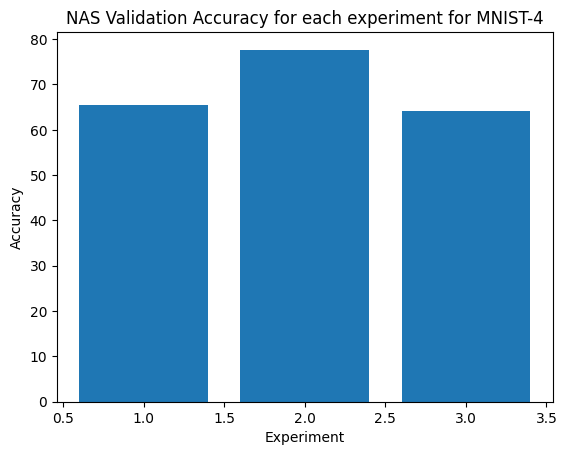

In [ ]:
print(valid_acc_list)
import matplotlib.pyplot as plt
valid_plot=[]
for i in range(len(valid_acc_list)):
    valid_plot.append(valid_acc_list[i][-1][-1])

plt.bar(range(1,1+len(valid_plot)),valid_plot)
plt.xlabel('Experiment')
plt.ylabel('Accuracy')
plt.title('NAS Validation Accuracy for each experiment for MNIST-4')
plt.show()

# ANN Model for the trained QNN

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/30
16/16 [==============================] - 1s 15ms/step - loss: 1.2248 - accuracy: 0.5106 - val_loss: 1.1038 - val_accuracy: 0.6500
Epoch 2/30
16/16 [==============================] - 0s 10ms/step - loss: 1.0315 - accuracy: 0.6561 - val_loss: 0.9599 - val_accuracy: 0.6500
Epoch 3/30
16/16 [==============================] - 0s 9ms/step - loss: 0.9285 - accuracy: 0.6616 - val_loss: 0.8744 - val_accuracy: 0.7000
Epoch 4/30
16/16 [==============================] - 0s 9ms/step - loss: 0.8750 - accuracy: 0.6646 - val_loss: 0.8342 - val_accuracy: 0.7000
Epoch 5/30
16/16 [==============================] - 0s 10ms/step - loss: 0.8524 - accuracy: 0.6702 - val_loss: 0.8065 - val_accuracy: 0.6500
Epoch 6/30
16/16 [==============================] - 0s 5ms/step - loss: 0.8401 - accuracy: 0.6798 - val_loss: 0.8022 - val_accuracy: 0.6500
Epoch 7/30
16/16 [==============================] - 0s 5ms/step - loss: 0.8306 - accuracy: 0.6818 - val_loss: 0.8031 - val_accuracy: 0.6500
Epoch 8/30
16/16 

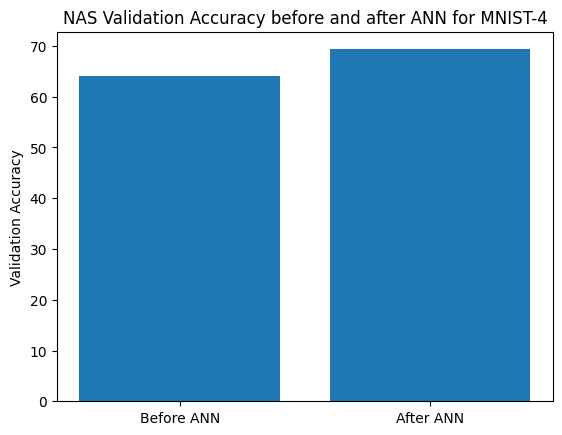

In [ ]:
n=0
for data in dataflow['train']:
        if n==0:
            inputs_train = data['image']
            targets_train = data['digit']
            # print(data['image'].shape)
        else:
            inputs_train = torch.cat((inputs_train, data['image']), 0)

            targets_train = torch.cat((targets_train, data['digit']), 0)
        n+=1
n=0
for data in dataflow['valid']:
        if n==0:
            inputs_valid = data['image']
            targets_valid = data['digit']
            # print(data['image'].shape)
        else:
            inputs_valid = torch.cat((inputs_valid, data['image']), 0)

            targets_valid = torch.cat((targets_valid, data['digit']), 0)
        n+=1

#  ANN Model
model_ann = Sequential([
    Dense(64, activation='relu', input_shape=(4,)),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
    ])

model_ann.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

output_qnn=model2(inputs_train.cuda())
target_train_data=targets_train.cpu().detach().numpy()
output_qnn=output_qnn.cpu().detach().numpy()
# print(output_qnn.shape)
# output_qnn, indices = output_1.topk(1, dim=1)

output_valid_qnn=model2(inputs_valid.cuda())
output_valid_qnn=output_valid_qnn.cpu().detach().numpy()
target_val_data=targets_valid.cpu().detach().numpy()


model_ann.fit(output_qnn, target_train_data , epochs=30, batch_size=128, validation_split=0.01)
output_valid_ann=model_ann.predict(output_valid_qnn)
accuracy=np.mean(np.argmax(output_valid_ann, axis=1) == target_val_data)

print(accuracy)

plt.bar(['Before ANN', 'After ANN'], [valid_acc_list[-1][-1][-1], accuracy*100])
plt.ylabel('Validation Accuracy')
plt.title('NAS Validation Accuracy before and after ANN for MNIST-4')
plt.show()



In [ ]:
import time
# model_encoder_lenet.to('cpu')
start_time = time.time()

# inputs_train=model_encoder_lenet(inputs_train)
output_exp1=model2(inputs_train.cuda())
output_exp1=output_exp1.cpu().detach().numpy()

time_taken1=time.time()-start_time

start_time=time.time()
output_exp2=model2(inputs_train.cuda())
output_exp2=output_exp2.cpu().detach().numpy()
# output_exp2_reshaped = output_exp2.reshape(-1, 10, 1)
# output_exp2_ann=model_cnn_after.predict(output_exp2_reshaped)
output_exp2_ann =model_ann.predict(output_exp2)

time_taken2=time.time()-start_time

print(f"Time taken for the first experiment QNN: {time_taken1}")
print(f"Time taken for the second experiment QNN+ANN: {time_taken2}")

63/63 [==============================] - 0s 2ms/step
Time taken for the first experiment QNN: 0.044999122619628906
Time taken for the second experiment QNN+ANN: 0.2299649715423584


## Ensemble Learning

In [ ]:

from torchquantum.plugins import QiskitProcessor
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten

from qiskit import IBMQ
IBMQ.save_account('b45e8d28e72f73d5a608f7a019b299b75a43080a7fc7ac1c222715e9816b0ab74c41156995f37ca4c84f270863b11d3cc5de9be8a434c3d5da7cbaba21ab5d7a', overwrite=True)
if torch.cuda.is_available():
    device = torch.device('cuda')

model_num=5
model_list_qnn=[]
model_list_ann=[]
n_epochs = 4
valid_acc_list=[]
test_acc_list=[]
random_digits_list=[]

for i in range(model_num):
    model2 = SuperQFCModel0(configs.model.arch)
    state_dict = io.load('max-acc-valid.pt',map_location='cpu')
    model2.load_state_dict(state_dict['model'], strict=False)
    model2.to(device)
    model2.set_sample_arch([4,4,4,4,4,4,3])


    optimizer1=optim.Adam(model2.parameters(),lr=5e-2,weight_decay=1e-4)
    scheduler1 = CosineAnnealingLR(optimizer1, T_max=n_epochs)
    # print(model2.sample_arch)
    # Choosing different dataflow with different classes for training. The first model train with [0,1,2,3], second model with [4,5,6,7], third model with [8,9,0,1], and other models with random digits.
    if i==0:
         random_digits=[0,1,2,3]
    elif i==1:
        random_digits=[4,5,6,7]
    elif i==2:
        random_digits=[8,9,0,1]
    else:
        random_digits=random.sample(range(10),4)
        if random_digits in random_digits_list:
            while random_digits in random_digits_list:
                random_digits=random.sample(range(10),4)

    random_digits_list.append(random_digits)
    print(random_digits)
    dataset= MNIST(
        root='./mnist_data',
        train_valid_split_ratio=[0.9, 0.1],
        digits_of_interest=random_digits,
        n_test_samples=600,
        n_train_samples=2000,
        n_valid_samples=600,
        # fashion=True
        )
    dataflow = dict()
    for split in dataset:
        sampler = torch.utils.data.RandomSampler(dataset[split])
        dataflow[split] = torch.utils.data.DataLoader(
            dataset[split],
            batch_size=configs.run.bsz,
            sampler=sampler,
            num_workers=configs.run.workers_per_gpu,
            pin_memory=True)

    processor_real_qc = QiskitProcessor(use_real_qc=False, noise_model_name = 'ibm_osaka', backend_name='ibm_osaka',)
    processor_real_qc.set_layout(random_digits) # default layout: virtual qubit 0 for physical qubit 0, ..., virtual qubit 3 for physical qubit 3
    model2.set_qiskit_processor(processor_real_qc)


#     agent = RandomSearcher(model2.arch_space, evaluate_gene,model2)
#     acc, gene = agent.run_search(3)
#     print(gene)
#     model2.set_sample_arch(gene)

    for epoch in range(1, n_epochs + 1):

            print(f"Epoch {epoch}:")
            train_step(dataflow, model2, device, optimizer1)
            print(optimizer1.param_groups[0]["lr"])

            # valid_test(dataflow, "valid", model2, device)
            scheduler1.step()
    # pruniing the model
    if isinstance(configs.optimizer.lr, str):
        configs.optimizer.lr = eval(configs.optimizer.lr)
    if isinstance(configs.optimizer.weight_decay, str):
        configs.optimizer.weight_decay = eval(configs.optimizer.weight_decay)
    configs.prune.target_pruning_amout = 0.5
    n_finetune_epochs = 2
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(
        model2.parameters(),
        lr=configs.optimizer.lr,
        weight_decay=configs.optimizer.weight_decay)

    scheduler = CosineAnnealingLR(optimizer, T_max=configs.run.n_epochs)
    trainer = PruningTrainer(model=model2,
                        criterion=criterion,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        )
    run_dir = 'runs/quantumnas/'
    set_run_dir(run_dir)
    logger.info(' '.join([sys.executable] + sys.argv))
    logger.info(f'Pruning started: "{run_dir}".' + '\n' +f'{configs}')
    callbacks = make_callbacks(dataflow)
    trainer.train_with_defaults(
        dataflow['train'],
        num_epochs=n_finetune_epochs,
        callbacks=callbacks)
    valid_acc_list.append(trainer.summary.history['acc/valid'])
    test_acc_list.append(trainer.summary.history['acc/test'])
    model_list_qnn.append(model2)

    #  ANN Model
    model_ann = Sequential([
    Dense(64, activation='relu', input_shape=(4,)),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
    ])

    model_ann.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    n=0
    for data in dataflow['train']:
        if n==0:
            inputs_train = data['image']
            targets_train = data['digit']

        else:
            inputs_train = torch.cat((inputs_train, data['image']), 0)
            targets_train = torch.cat((targets_train, data['digit']), 0)
        n+=1
    n=0
    for data in dataflow['valid']:
        if n==0:
            inputs_valid = data['image']
            targets_valid = data['digit']

        else:
            inputs_valid = torch.cat((inputs_valid, data['image']), 0)
            targets_valid = torch.cat((targets_valid, data['digit']), 0)
        n+=1

    target_train_data=targets_train.cpu().detach().numpy()
    output_qnn=model2(inputs_train.cuda())
    output_qnn=output_qnn.cpu().detach().numpy()

    # output_qnn, indices = output_1.topk(1, dim=1)

    output_valid_qnn=model2(inputs_valid.cuda())
    output_valid_qnn=output_valid_qnn.cpu().detach().numpy()
    target_val_data=targets_valid.cpu().detach().numpy()


    model_ann.fit(output_qnn, target_train_data , epochs=30, batch_size=128, validation_split=0.01)
    output_valid_ann=model_ann.predict(output_valid_qnn)
    accuracy=np.mean(np.argmax(output_valid_ann, axis=1) == target_val_data)

    print(accuracy)
    model_list_ann.append(model_ann)








[2024-06-13 19:51:56.476] Only use the front 2000 images as TRAIN set.


[0, 1, 2, 3]


[2024-06-13 19:51:56.590] Only use the front 600 images as VALID set.
[2024-06-13 19:51:56.607] Only use the front 600 images as TEST set.
ibmqfactory.load_account:WARNING:2024-06-13 19:51:56,870: Credentials are already in use. The existing account in the session will be replaced.


Epoch 1:
0.05
Epoch 2:
0.04267766952966369
Epoch 3:
0.025
Epoch 4:


[2024-06-13 19:52:08.536] /usr/bin/python3 /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-fc81fc86-4c2c-4ace-a228-03442c423279.json
[2024-06-13 19:52:08.543] Pruning started: "runs/quantumnas/".
model:
  arch:
    n_wires: 4
    encoder_op_list_name: 4x4_ryzxy
    n_blocks: 3
    n_layers_per_block: 2
    q_layer_name: u3cu3_s0
    down_sample_kernel_size: 6
    n_front_share_blocks: 1
    n_front_share_wires: 1
    n_front_share_ops: 1
  sampler:
    strategy:
      name: plain
  transpile_before_run: False
  load_op_list: False
dataset:
  name: mnist
  input_name: image
  target_name: digit
optimizer:
  name: adam
  lr: 0.05
  weight_decay: 0.0001
  lambda_lr: 1e-2
run:
  n_epochs: 40
  bsz: 128
  workers_per_gpu: 2
  device: gpu
debug:
  pdb: False
  set_seed: True
  seed: 42
callbacks: [{'callback': 'InferenceRunner', 'split': 'valid', 'subcallbacks': [{'metrics': 'CategoricalAccuracy', 'name': 'acc/valid'}, {'metrics':

0.0073223304703363135


  0% 0/16 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[2024-06-13 19:52:11.566] Training finished in 3 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 19:52:13.326] Inference finished in 1.75 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 19:52:15.488] Inference finished in 2.15 seconds.
[2024-06-13 19:52:15.742] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (78.833).
[2024-06-13 19:52:15.927] Checkpoint saved: "runs/quantumnas/checkpoints/step-16.pt".
[2024-06-13 19:52:15.933] 
+ [acc/test] = 78.667
+ [acc/valid] = 78.833
+ [acc/valid/max] = 78.833
+ [loss] = 0.58559
+ [loss/test] = 0.52382
+ [loss/valid] = 0.53063
+ [lr/lr_group0] = 0.05
+ [nll_loss] = 0.58559
+ [prune_amount] = 0.1
[2024-06-13 19:52:15.939] Estimated time left: 7.37 seconds.
[2024-06-13 19:52:15.943] Epoch finished in 7.37 seconds.
[2024-06-13 19:52:15.949] Epoch 2/2 started.


  0% 0/16 [00:00<?, ?it/s]

[2024-06-13 19:52:18.378] Training finished in 2.42 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 19:52:19.527] Inference finished in 1.14 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 19:52:20.651] Inference finished in 1.11 seconds.
[2024-06-13 19:52:20.782] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (79.833).
[2024-06-13 19:52:20.868] Checkpoint saved: "runs/quantumnas/checkpoints/step-32.pt".
[2024-06-13 19:52:20.875] 
+ [acc/test] = 80.333
+ [acc/valid] = 79.833
+ [acc/valid/max] = 79.833
+ [loss] = 0.44974
+ [loss/test] = 0.49733
+ [loss/valid] = 0.54875
+ [lr/lr_group0] = 0.049923
+ [nll_loss] = 0.44974
+ [prune_amount] = 0.13868
[2024-06-13 19:52:20.880] Epoch finished in 4.93 seconds.
[2024-06-13 19:52:20.884] 2 epochs of training finished in 12.3 seconds.


Epoch 1/30
16/16 [==============================] - 2s 23ms/step - loss: 1.3870 - accuracy: 0.3566 - val_loss: 0.9891 - val_accuracy: 0.5000
Epoch 2/30
16/16 [==============================] - 0s 8ms/step - loss: 0.7844 - accuracy: 0.7394 - val_loss: 0.6156 - val_accuracy: 0.8500
Epoch 3/30
16/16 [==============================] - 0s 8ms/step - loss: 0.5798 - accuracy: 0.7995 - val_loss: 0.4507 - val_accuracy: 0.9000
Epoch 4/30
16/16 [==============================] - 0s 8ms/step - loss: 0.5048 - accuracy: 0.8091 - val_loss: 0.3777 - val_accuracy: 0.9000
Epoch 5/30
16/16 [==============================] - 0s 5ms/step - loss: 0.4764 - accuracy: 0.8101 - val_loss: 0.3453 - val_accuracy: 0.9000
Epoch 6/30
16/16 [==============================] - 0s 6ms/step - loss: 0.4605 - accuracy: 0.8131 - val_loss: 0.3181 - val_accuracy: 0.9000
Epoch 7/30
16/16 [==============================] - 0s 5ms/step - loss: 0.4572 - accuracy: 0.8172 - val_loss: 0.3185 - val_accuracy: 0.9000
Epoch 8/30
16/16 [=

[2024-06-13 19:52:59.590] Only use the front 2000 images as TRAIN set.
[2024-06-13 19:52:59.678] Only use the front 600 images as VALID set.
[2024-06-13 19:52:59.701] Only use the front 600 images as TEST set.
ibmqfactory.load_account:WARNING:2024-06-13 19:53:00,008: Credentials are already in use. The existing account in the session will be replaced.


Epoch 1:
0.05
Epoch 2:
0.04267766952966369
Epoch 3:
0.025
Epoch 4:


[2024-06-13 19:53:12.523] /usr/bin/python3 /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-fc81fc86-4c2c-4ace-a228-03442c423279.json
[2024-06-13 19:53:12.530] Pruning started: "runs/quantumnas/".
model:
  arch:
    n_wires: 4
    encoder_op_list_name: 4x4_ryzxy
    n_blocks: 3
    n_layers_per_block: 2
    q_layer_name: u3cu3_s0
    down_sample_kernel_size: 6
    n_front_share_blocks: 1
    n_front_share_wires: 1
    n_front_share_ops: 1
  sampler:
    strategy:
      name: plain
  transpile_before_run: False
  load_op_list: False
dataset:
  name: mnist
  input_name: image
  target_name: digit
optimizer:
  name: adam
  lr: 0.05
  weight_decay: 0.0001
  lambda_lr: 1e-2
run:
  n_epochs: 40
  bsz: 128
  workers_per_gpu: 2
  device: gpu
debug:
  pdb: False
  set_seed: True
  seed: 42
callbacks: [{'callback': 'InferenceRunner', 'split': 'valid', 'subcallbacks': [{'metrics': 'CategoricalAccuracy', 'name': 'acc/valid'}, {'metrics':

0.0073223304703363135


  0% 0/16 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[2024-06-13 19:53:15.071] Training finished in 2.51 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 19:53:16.228] Inference finished in 1.15 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 19:53:17.392] Inference finished in 1.15 seconds.
[2024-06-13 19:53:17.517] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (47.667).
[2024-06-13 19:53:17.613] Checkpoint saved: "runs/quantumnas/checkpoints/step-16.pt".
[2024-06-13 19:53:17.620] 
+ [acc/test] = 48
+ [acc/valid] = 47.667
+ [acc/valid/max] = 47.667
+ [loss] = 0.6467
+ [loss/test] = 1.3422
+ [loss/valid] = 1.3765
+ [lr/lr_group0] = 0.05
+ [nll_loss] = 0.6467
+ [prune_amount] = 0.1
[2024-06-13 19:53:17.626] Estimated time left: 5.07 seconds.
[2024-06-13 19:53:17.631] Epoch finished in 5.07 seconds.
[2024-06-13 19:53:17.636] Epoch 2/2 started.


  0% 0/16 [00:00<?, ?it/s]

[2024-06-13 19:53:20.118] Training finished in 2.48 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 19:53:21.588] Inference finished in 1.46 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 19:53:23.378] Inference finished in 1.77 seconds.
[2024-06-13 19:53:23.583] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (68.333).
[2024-06-13 19:54:03.830] Checkpoint saved: "runs/quantumnas/checkpoints/step-32.pt".
[2024-06-13 19:54:03.840] 
+ [acc/test] = 61.167
+ [acc/valid] = 68.333
+ [acc/valid/max] = 68.333
+ [loss] = 0.72986
+ [loss/test] = 0.91287
+ [loss/valid] = 0.82771
+ [lr/lr_group0] = 0.049923
+ [nll_loss] = 0.72986
+ [prune_amount] = 0.13868
[2024-06-13 19:54:03.847] Epoch finished in 46.2 seconds.
[2024-06-13 19:54:03.853] 2 epochs of training finished in 51.3 seconds.


Epoch 1/30
16/16 [==============================] - 1s 20ms/step - loss: 1.3506 - accuracy: 0.4081 - val_loss: 1.3415 - val_accuracy: 0.3500
Epoch 2/30
16/16 [==============================] - 0s 7ms/step - loss: 0.9598 - accuracy: 0.6515 - val_loss: 1.0491 - val_accuracy: 0.5500
Epoch 3/30
16/16 [==============================] - 0s 7ms/step - loss: 0.8062 - accuracy: 0.7096 - val_loss: 1.0219 - val_accuracy: 0.5500
Epoch 4/30
16/16 [==============================] - 0s 8ms/step - loss: 0.7419 - accuracy: 0.7359 - val_loss: 0.9822 - val_accuracy: 0.6000
Epoch 5/30
16/16 [==============================] - 0s 8ms/step - loss: 0.7168 - accuracy: 0.7303 - val_loss: 0.9564 - val_accuracy: 0.6000
Epoch 6/30
16/16 [==============================] - 0s 8ms/step - loss: 0.6967 - accuracy: 0.7343 - val_loss: 0.9612 - val_accuracy: 0.6000
Epoch 7/30
16/16 [==============================] - 0s 8ms/step - loss: 0.6858 - accuracy: 0.7384 - val_loss: 0.9970 - val_accuracy: 0.6000
Epoch 8/30
16/16 [=

[2024-06-13 19:54:11.189] Only use the front 2000 images as TRAIN set.
[2024-06-13 19:54:11.296] Only use the front 600 images as VALID set.
[2024-06-13 19:54:11.316] Only use the front 600 images as TEST set.
ibmqfactory.load_account:WARNING:2024-06-13 19:54:11,501: Credentials are already in use. The existing account in the session will be replaced.


Epoch 1:
0.05
Epoch 2:
0.04267766952966369
Epoch 3:
0.025
Epoch 4:


[2024-06-13 19:54:23.063] /usr/bin/python3 /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-fc81fc86-4c2c-4ace-a228-03442c423279.json
[2024-06-13 19:54:23.073] Pruning started: "runs/quantumnas/".
model:
  arch:
    n_wires: 4
    encoder_op_list_name: 4x4_ryzxy
    n_blocks: 3
    n_layers_per_block: 2
    q_layer_name: u3cu3_s0
    down_sample_kernel_size: 6
    n_front_share_blocks: 1
    n_front_share_wires: 1
    n_front_share_ops: 1
  sampler:
    strategy:
      name: plain
  transpile_before_run: False
  load_op_list: False
dataset:
  name: mnist
  input_name: image
  target_name: digit
optimizer:
  name: adam
  lr: 0.05
  weight_decay: 0.0001
  lambda_lr: 1e-2
run:
  n_epochs: 40
  bsz: 128
  workers_per_gpu: 2
  device: gpu
debug:
  pdb: False
  set_seed: True
  seed: 42
callbacks: [{'callback': 'InferenceRunner', 'split': 'valid', 'subcallbacks': [{'metrics': 'CategoricalAccuracy', 'name': 'acc/valid'}, {'metrics':

0.0073223304703363135


  0% 0/16 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[2024-06-13 19:54:26.147] Training finished in 3.04 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 19:54:27.295] Inference finished in 1.14 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 19:54:28.404] Inference finished in 1.1 seconds.
[2024-06-13 19:54:28.531] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (86.333).
[2024-06-13 19:54:28.622] Checkpoint saved: "runs/quantumnas/checkpoints/step-16.pt".
[2024-06-13 19:54:28.627] 
+ [acc/test] = 89.167
+ [acc/valid] = 86.333
+ [acc/valid/max] = 86.333
+ [loss] = 0.31067
+ [loss/test] = 0.31304
+ [loss/valid] = 0.37644
+ [lr/lr_group0] = 0.05
+ [nll_loss] = 0.31067
+ [prune_amount] = 0.1
[2024-06-13 19:54:28.633] Estimated time left: 5.53 seconds.
[2024-06-13 19:54:28.637] Epoch finished in 5.53 seconds.
[2024-06-13 19:54:28.643] Epoch 2/2 started.


  0% 0/16 [00:00<?, ?it/s]

[2024-06-13 19:54:31.030] Training finished in 2.38 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 19:54:32.171] Inference finished in 1.13 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 19:54:33.304] Inference finished in 1.12 seconds.
[2024-06-13 19:54:33.424] Checkpoint saved: "runs/quantumnas/checkpoints/step-32.pt".
[2024-06-13 19:54:33.433] 
+ [acc/test] = 87.667
+ [acc/valid] = 83.5
+ [acc/valid/max] = 86.333
+ [loss] = 0.2627
+ [loss/test] = 0.35681
+ [loss/valid] = 0.44091
+ [lr/lr_group0] = 0.049923
+ [nll_loss] = 0.2627
+ [prune_amount] = 0.13868
[2024-06-13 19:54:33.439] Epoch finished in 4.79 seconds.
[2024-06-13 19:54:33.443] 2 epochs of training finished in 10.4 seconds.


Epoch 1/30
16/16 [==============================] - 2s 24ms/step - loss: 1.4081 - accuracy: 0.4576 - val_loss: 0.9259 - val_accuracy: 0.5000
Epoch 2/30
16/16 [==============================] - 0s 8ms/step - loss: 0.6856 - accuracy: 0.8566 - val_loss: 0.6009 - val_accuracy: 0.8500
Epoch 3/30
16/16 [==============================] - 0s 9ms/step - loss: 0.4128 - accuracy: 0.8960 - val_loss: 0.4996 - val_accuracy: 0.8500
Epoch 4/30
16/16 [==============================] - 0s 10ms/step - loss: 0.3227 - accuracy: 0.9035 - val_loss: 0.4795 - val_accuracy: 0.8500
Epoch 5/30
16/16 [==============================] - 0s 8ms/step - loss: 0.2951 - accuracy: 0.9030 - val_loss: 0.4736 - val_accuracy: 0.8500
Epoch 6/30
16/16 [==============================] - 0s 8ms/step - loss: 0.2829 - accuracy: 0.9081 - val_loss: 0.4833 - val_accuracy: 0.8500
Epoch 7/30
16/16 [==============================] - 0s 9ms/step - loss: 0.2786 - accuracy: 0.9056 - val_loss: 0.4851 - val_accuracy: 0.8000
Epoch 8/30
16/16 [

[2024-06-13 19:55:21.703] Only use the front 2000 images as TRAIN set.


0.88
[2, 3, 9, 5]


[2024-06-13 19:55:21.808] Only use the front 600 images as VALID set.
[2024-06-13 19:55:21.830] Only use the front 600 images as TEST set.
ibmqfactory.load_account:WARNING:2024-06-13 19:55:22,004: Credentials are already in use. The existing account in the session will be replaced.


Epoch 1:
0.05
Epoch 2:
0.04267766952966369
Epoch 3:
0.025
Epoch 4:


[2024-06-13 19:55:36.470] /usr/bin/python3 /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-fc81fc86-4c2c-4ace-a228-03442c423279.json
[2024-06-13 19:55:36.479] Pruning started: "runs/quantumnas/".
model:
  arch:
    n_wires: 4
    encoder_op_list_name: 4x4_ryzxy
    n_blocks: 3
    n_layers_per_block: 2
    q_layer_name: u3cu3_s0
    down_sample_kernel_size: 6
    n_front_share_blocks: 1
    n_front_share_wires: 1
    n_front_share_ops: 1
  sampler:
    strategy:
      name: plain
  transpile_before_run: False
  load_op_list: False
dataset:
  name: mnist
  input_name: image
  target_name: digit
optimizer:
  name: adam
  lr: 0.05
  weight_decay: 0.0001
  lambda_lr: 1e-2
run:
  n_epochs: 40
  bsz: 128
  workers_per_gpu: 2
  device: gpu
debug:
  pdb: False
  set_seed: True
  seed: 42
callbacks: [{'callback': 'InferenceRunner', 'split': 'valid', 'subcallbacks': [{'metrics': 'CategoricalAccuracy', 'name': 'acc/valid'}, {'metrics':

0.0073223304703363135


  0% 0/16 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[2024-06-13 19:55:39.179] Training finished in 2.66 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 19:55:40.387] Inference finished in 1.2 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 19:55:51.418] Inference finished in 11 seconds.
[2024-06-13 19:55:51.546] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (63.167).
[2024-06-13 19:55:51.644] Checkpoint saved: "runs/quantumnas/checkpoints/step-16.pt".
[2024-06-13 19:55:51.649] 
+ [acc/test] = 57.167
+ [acc/valid] = 63.167
+ [acc/valid/max] = 63.167
+ [loss] = 1.0172
+ [loss/test] = 0.97064
+ [loss/valid] = 0.91607
+ [lr/lr_group0] = 0.05
+ [nll_loss] = 1.0172
+ [prune_amount] = 0.1
[2024-06-13 19:55:51.656] Estimated time left: 15.1 seconds.
[2024-06-13 19:55:51.660] Epoch finished in 15.1 seconds.
[2024-06-13 19:55:51.666] Epoch 2/2 started.


  0% 0/16 [00:00<?, ?it/s]

[2024-06-13 19:55:54.186] Training finished in 2.51 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 19:55:55.429] Inference finished in 1.23 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 19:55:56.640] Inference finished in 1.2 seconds.
[2024-06-13 19:55:56.771] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (64.5).
[2024-06-13 19:55:56.867] Checkpoint saved: "runs/quantumnas/checkpoints/step-32.pt".
[2024-06-13 19:55:56.873] 
+ [acc/test] = 63
+ [acc/valid] = 64.5
+ [acc/valid/max] = 64.5
+ [loss] = 0.79819
+ [loss/test] = 0.90319
+ [loss/valid] = 0.87067
+ [lr/lr_group0] = 0.049923
+ [nll_loss] = 0.79819
+ [prune_amount] = 0.13868
[2024-06-13 19:55:56.880] Epoch finished in 5.21 seconds.
[2024-06-13 19:55:56.886] 2 epochs of training finished in 20.4 seconds.


Epoch 1/30
16/16 [==============================] - 23s 21ms/step - loss: 1.2224 - accuracy: 0.4020 - val_loss: 1.1349 - val_accuracy: 0.4500
Epoch 2/30
16/16 [==============================] - 0s 7ms/step - loss: 1.0004 - accuracy: 0.5586 - val_loss: 1.0204 - val_accuracy: 0.6500
Epoch 3/30
16/16 [==============================] - 0s 7ms/step - loss: 0.9297 - accuracy: 0.6157 - val_loss: 0.9634 - val_accuracy: 0.6000
Epoch 4/30
16/16 [==============================] - 0s 8ms/step - loss: 0.8963 - accuracy: 0.6374 - val_loss: 0.9572 - val_accuracy: 0.6500
Epoch 5/30
16/16 [==============================] - 0s 8ms/step - loss: 0.8751 - accuracy: 0.6394 - val_loss: 0.9095 - val_accuracy: 0.6500
Epoch 6/30
16/16 [==============================] - 0s 8ms/step - loss: 0.8627 - accuracy: 0.6449 - val_loss: 0.9669 - val_accuracy: 0.6000
Epoch 7/30
16/16 [==============================] - 0s 8ms/step - loss: 0.8541 - accuracy: 0.6429 - val_loss: 0.8987 - val_accuracy: 0.6500
Epoch 8/30
16/16 [

[2024-06-13 19:56:47.444] Only use the front 2000 images as TRAIN set.


0.6666666666666666
[2, 7, 8, 3]


[2024-06-13 19:56:47.551] Only use the front 600 images as VALID set.
[2024-06-13 19:56:47.572] Only use the front 600 images as TEST set.
ibmqfactory.load_account:WARNING:2024-06-13 19:56:47,784: Credentials are already in use. The existing account in the session will be replaced.


Epoch 1:
0.05
Epoch 2:
0.04267766952966369
Epoch 3:
0.025
Epoch 4:


[2024-06-13 19:57:00.624] /usr/bin/python3 /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-fc81fc86-4c2c-4ace-a228-03442c423279.json
[2024-06-13 19:57:00.630] Pruning started: "runs/quantumnas/".
model:
  arch:
    n_wires: 4
    encoder_op_list_name: 4x4_ryzxy
    n_blocks: 3
    n_layers_per_block: 2
    q_layer_name: u3cu3_s0
    down_sample_kernel_size: 6
    n_front_share_blocks: 1
    n_front_share_wires: 1
    n_front_share_ops: 1
  sampler:
    strategy:
      name: plain
  transpile_before_run: False
  load_op_list: False
dataset:
  name: mnist
  input_name: image
  target_name: digit
optimizer:
  name: adam
  lr: 0.05
  weight_decay: 0.0001
  lambda_lr: 1e-2
run:
  n_epochs: 40
  bsz: 128
  workers_per_gpu: 2
  device: gpu
debug:
  pdb: False
  set_seed: True
  seed: 42
callbacks: [{'callback': 'InferenceRunner', 'split': 'valid', 'subcallbacks': [{'metrics': 'CategoricalAccuracy', 'name': 'acc/valid'}, {'metrics':

0.0073223304703363135


  0% 0/16 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[2024-06-13 19:57:03.272] Training finished in 2.62 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 19:57:04.559] Inference finished in 1.28 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 19:57:05.809] Inference finished in 1.24 seconds.
[2024-06-13 19:57:05.942] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (63.833).
[2024-06-13 19:57:06.045] Checkpoint saved: "runs/quantumnas/checkpoints/step-16.pt".
[2024-06-13 19:57:06.051] 
+ [acc/test] = 57.333
+ [acc/valid] = 63.833
+ [acc/valid/max] = 63.833
+ [loss] = 0.89669
+ [loss/test] = 0.97422
+ [loss/valid] = 0.92679
+ [lr/lr_group0] = 0.05
+ [nll_loss] = 0.89669
+ [prune_amount] = 0.1
[2024-06-13 19:57:06.059] Estimated time left: 5.41 seconds.
[2024-06-13 19:57:06.064] Epoch finished in 5.41 seconds.
[2024-06-13 19:57:06.069] Epoch 2/2 started.


  0% 0/16 [00:00<?, ?it/s]

[2024-06-13 19:57:08.675] Training finished in 2.6 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 19:57:10.577] Inference finished in 1.89 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 19:57:12.421] Inference finished in 1.83 seconds.
[2024-06-13 19:57:12.640] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (65.167).
[2024-06-13 19:57:42.906] Checkpoint saved: "runs/quantumnas/checkpoints/step-32.pt".
[2024-06-13 19:57:42.914] 
+ [acc/test] = 59
+ [acc/valid] = 65.167
+ [acc/valid/max] = 65.167
+ [loss] = 0.84376
+ [loss/test] = 0.93702
+ [loss/valid] = 0.89241
+ [lr/lr_group0] = 0.049923
+ [nll_loss] = 0.84376
+ [prune_amount] = 0.13868
[2024-06-13 19:57:42.923] Epoch finished in 36.8 seconds.
[2024-06-13 19:57:42.935] 2 epochs of training finished in 42.3 seconds.


Epoch 1/30
16/16 [==============================] - 1s 17ms/step - loss: 1.1842 - accuracy: 0.4439 - val_loss: 0.9977 - val_accuracy: 0.5000
Epoch 2/30
16/16 [==============================] - 0s 5ms/step - loss: 0.9599 - accuracy: 0.6247 - val_loss: 0.8648 - val_accuracy: 0.6000
Epoch 3/30
16/16 [==============================] - 0s 5ms/step - loss: 0.8885 - accuracy: 0.6475 - val_loss: 0.7898 - val_accuracy: 0.5500
Epoch 4/30
16/16 [==============================] - 0s 5ms/step - loss: 0.8590 - accuracy: 0.6535 - val_loss: 0.7643 - val_accuracy: 0.6000
Epoch 5/30
16/16 [==============================] - 0s 7ms/step - loss: 0.8421 - accuracy: 0.6530 - val_loss: 0.7498 - val_accuracy: 0.5500
Epoch 6/30
16/16 [==============================] - 0s 6ms/step - loss: 0.8374 - accuracy: 0.6566 - val_loss: 0.7222 - val_accuracy: 0.5000
Epoch 7/30
16/16 [==============================] - 0s 5ms/step - loss: 0.8309 - accuracy: 0.6591 - val_loss: 0.7213 - val_accuracy: 0.5500
Epoch 8/30
16/16 [=

[2024-06-13 19:57:51.233] Only use the front 2000 images as TRAIN set.
[2024-06-13 19:57:51.385] Only use the front 600 images as VALID set.
[2024-06-13 19:57:51.410] Only use the front 600 images as TEST set.
ibmqfactory.load_account:WARNING:2024-06-13 19:57:51,653: Credentials are already in use. The existing account in the session will be replaced.


Epoch 1:
0.05
Epoch 2:
0.04267766952966369
Epoch 3:
0.025
Epoch 4:


[2024-06-13 19:58:02.991] /usr/bin/python3 /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-fc81fc86-4c2c-4ace-a228-03442c423279.json
[2024-06-13 19:58:02.998] Pruning started: "runs/quantumnas/".
model:
  arch:
    n_wires: 4
    encoder_op_list_name: 4x4_ryzxy
    n_blocks: 3
    n_layers_per_block: 2
    q_layer_name: u3cu3_s0
    down_sample_kernel_size: 6
    n_front_share_blocks: 1
    n_front_share_wires: 1
    n_front_share_ops: 1
  sampler:
    strategy:
      name: plain
  transpile_before_run: False
  load_op_list: False
dataset:
  name: mnist
  input_name: image
  target_name: digit
optimizer:
  name: adam
  lr: 0.05
  weight_decay: 0.0001
  lambda_lr: 1e-2
run:
  n_epochs: 40
  bsz: 128
  workers_per_gpu: 2
  device: gpu
debug:
  pdb: False
  set_seed: True
  seed: 42
callbacks: [{'callback': 'InferenceRunner', 'split': 'valid', 'subcallbacks': [{'metrics': 'CategoricalAccuracy', 'name': 'acc/valid'}, {'metrics':

0.0073223304703363135


  0% 0/16 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[2024-06-13 19:58:06.545] Training finished in 3.51 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 19:58:08.522] Inference finished in 1.97 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 19:58:09.784] Inference finished in 1.25 seconds.
[2024-06-13 19:58:09.917] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (50.5).
[2024-06-13 19:58:10.012] Checkpoint saved: "runs/quantumnas/checkpoints/step-16.pt".
[2024-06-13 19:58:10.018] 
+ [acc/test] = 41
+ [acc/valid] = 50.5
+ [acc/valid/max] = 50.5
+ [loss] = 0.96491
+ [loss/test] = 1.4799
+ [loss/valid] = 1.2567
+ [lr/lr_group0] = 0.05
+ [nll_loss] = 0.96491
+ [prune_amount] = 0.1
[2024-06-13 19:58:10.026] Estimated time left: 7 seconds.
[2024-06-13 19:58:10.031] Epoch finished in 7 seconds.
[2024-06-13 19:58:10.037] Epoch 2/2 started.


  0% 0/16 [00:00<?, ?it/s]

[2024-06-13 19:58:12.546] Training finished in 2.5 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 19:58:13.994] Inference finished in 1.44 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 19:58:45.116] Inference finished in 31.1 seconds.
[2024-06-13 19:58:45.244] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (63.833).
[2024-06-13 19:58:45.345] Checkpoint saved: "runs/quantumnas/checkpoints/step-32.pt".
[2024-06-13 19:58:45.350] 
+ [acc/test] = 60.333
+ [acc/valid] = 63.833
+ [acc/valid/max] = 63.833
+ [loss] = 0.86141
+ [loss/test] = 1.0075
+ [loss/valid] = 0.96789
+ [lr/lr_group0] = 0.049923
+ [nll_loss] = 0.86141
+ [prune_amount] = 0.13868
[2024-06-13 19:58:45.356] Epoch finished in 35.3 seconds.
[2024-06-13 19:58:45.362] 2 epochs of training finished in 42.4 seconds.


Epoch 1/30
16/16 [==============================] - 2s 23ms/step - loss: 1.2667 - accuracy: 0.4540 - val_loss: 1.1067 - val_accuracy: 0.4500
Epoch 2/30
16/16 [==============================] - 0s 9ms/step - loss: 0.9560 - accuracy: 0.6455 - val_loss: 0.9294 - val_accuracy: 0.5000
Epoch 3/30
16/16 [==============================] - 0s 8ms/step - loss: 0.8526 - accuracy: 0.6596 - val_loss: 0.8555 - val_accuracy: 0.5000
Epoch 4/30
16/16 [==============================] - 0s 7ms/step - loss: 0.8145 - accuracy: 0.6652 - val_loss: 0.7981 - val_accuracy: 0.5500
Epoch 5/30
16/16 [==============================] - 0s 8ms/step - loss: 0.8026 - accuracy: 0.6712 - val_loss: 0.8033 - val_accuracy: 0.5500
Epoch 6/30
16/16 [==============================] - 0s 8ms/step - loss: 0.7950 - accuracy: 0.6727 - val_loss: 0.8456 - val_accuracy: 0.5000
Epoch 7/30
16/16 [==============================] - 0s 10ms/step - loss: 0.7885 - accuracy: 0.6788 - val_loss: 0.7896 - val_accuracy: 0.6000
Epoch 8/30
16/16 [

[2024-06-13 19:58:54.640] Only use the front 2000 images as TRAIN set.
[2024-06-13 19:58:54.789] Only use the front 600 images as VALID set.
[2024-06-13 19:58:54.824] Only use the front 600 images as TEST set.
ibmqfactory.load_account:WARNING:2024-06-13 19:58:55,039: Credentials are already in use. The existing account in the session will be replaced.


Epoch 1:
0.05
Epoch 2:
0.04267766952966369
Epoch 3:
0.025
Epoch 4:


[2024-06-13 19:59:08.098] /usr/bin/python3 /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-fc81fc86-4c2c-4ace-a228-03442c423279.json
[2024-06-13 19:59:08.105] Pruning started: "runs/quantumnas/".
model:
  arch:
    n_wires: 4
    encoder_op_list_name: 4x4_ryzxy
    n_blocks: 3
    n_layers_per_block: 2
    q_layer_name: u3cu3_s0
    down_sample_kernel_size: 6
    n_front_share_blocks: 1
    n_front_share_wires: 1
    n_front_share_ops: 1
  sampler:
    strategy:
      name: plain
  transpile_before_run: False
  load_op_list: False
dataset:
  name: mnist
  input_name: image
  target_name: digit
optimizer:
  name: adam
  lr: 0.05
  weight_decay: 0.0001
  lambda_lr: 1e-2
run:
  n_epochs: 40
  bsz: 128
  workers_per_gpu: 2
  device: gpu
debug:
  pdb: False
  set_seed: True
  seed: 42
callbacks: [{'callback': 'InferenceRunner', 'split': 'valid', 'subcallbacks': [{'metrics': 'CategoricalAccuracy', 'name': 'acc/valid'}, {'metrics':

0.0073223304703363135


  0% 0/16 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[2024-06-13 19:59:10.574] Training finished in 2.44 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 19:59:11.818] Inference finished in 1.24 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 19:59:13.014] Inference finished in 1.19 seconds.
[2024-06-13 19:59:13.146] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (76).
[2024-06-13 19:59:13.245] Checkpoint saved: "runs/quantumnas/checkpoints/step-16.pt".
[2024-06-13 19:59:13.251] 
+ [acc/test] = 75.333
+ [acc/valid] = 76
+ [acc/valid/max] = 76
+ [loss] = 0.74147
+ [loss/test] = 0.76419
+ [loss/valid] = 0.72836
+ [lr/lr_group0] = 0.05
+ [nll_loss] = 0.74147
+ [prune_amount] = 0.1
[2024-06-13 19:59:13.258] Estimated time left: 5.13 seconds.
[2024-06-13 19:59:13.264] Epoch finished in 5.13 seconds.
[2024-06-13 19:59:13.269] Epoch 2/2 started.


  0% 0/16 [00:00<?, ?it/s]

[2024-06-13 19:59:36.220] Training finished in 22.9 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 19:59:37.448] Inference finished in 1.22 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 19:59:38.668] Inference finished in 1.2 seconds.
[2024-06-13 19:59:38.798] Checkpoint saved: "runs/quantumnas/checkpoints/step-32.pt".
[2024-06-13 19:59:38.805] 
+ [acc/test] = 70
+ [acc/valid] = 73
+ [acc/valid/max] = 76
+ [loss] = 0.84592
+ [loss/test] = 0.80072
+ [loss/valid] = 0.71474
+ [lr/lr_group0] = 0.049923
+ [nll_loss] = 0.84592
+ [prune_amount] = 0.13868
[2024-06-13 19:59:38.812] Epoch finished in 25.5 seconds.
[2024-06-13 19:59:38.818] 2 epochs of training finished in 30.7 seconds.


Epoch 1/30
16/16 [==============================] - 22s 24ms/step - loss: 1.1823 - accuracy: 0.4778 - val_loss: 0.8940 - val_accuracy: 0.7000
Epoch 2/30
16/16 [==============================] - 0s 5ms/step - loss: 0.8393 - accuracy: 0.7490 - val_loss: 0.7341 - val_accuracy: 0.7000
Epoch 3/30
16/16 [==============================] - 0s 5ms/step - loss: 0.7247 - accuracy: 0.7525 - val_loss: 0.6236 - val_accuracy: 0.7500
Epoch 4/30
16/16 [==============================] - 0s 5ms/step - loss: 0.6803 - accuracy: 0.7566 - val_loss: 0.6087 - val_accuracy: 0.7000
Epoch 5/30
16/16 [==============================] - 0s 5ms/step - loss: 0.6614 - accuracy: 0.7566 - val_loss: 0.5529 - val_accuracy: 0.7500
Epoch 6/30
16/16 [==============================] - 0s 5ms/step - loss: 0.6554 - accuracy: 0.7631 - val_loss: 0.5443 - val_accuracy: 0.7500
Epoch 7/30
16/16 [==============================] - 0s 5ms/step - loss: 0.6522 - accuracy: 0.7606 - val_loss: 0.5250 - val_accuracy: 0.7500
Epoch 8/30
16/16 [

[2024-06-13 20:00:05.770] Only use the front 2000 images as TRAIN set.
[2024-06-13 20:00:05.889] Only use the front 600 images as VALID set.
[2024-06-13 20:00:05.908] Only use the front 600 images as TEST set.
ibmqfactory.load_account:WARNING:2024-06-13 20:00:06,115: Credentials are already in use. The existing account in the session will be replaced.


Epoch 1:
0.05
Epoch 2:
0.04267766952966369
Epoch 3:
0.025
Epoch 4:


[2024-06-13 20:00:19.249] /usr/bin/python3 /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-fc81fc86-4c2c-4ace-a228-03442c423279.json
[2024-06-13 20:00:19.255] Pruning started: "runs/quantumnas/".
model:
  arch:
    n_wires: 4
    encoder_op_list_name: 4x4_ryzxy
    n_blocks: 3
    n_layers_per_block: 2
    q_layer_name: u3cu3_s0
    down_sample_kernel_size: 6
    n_front_share_blocks: 1
    n_front_share_wires: 1
    n_front_share_ops: 1
  sampler:
    strategy:
      name: plain
  transpile_before_run: False
  load_op_list: False
dataset:
  name: mnist
  input_name: image
  target_name: digit
optimizer:
  name: adam
  lr: 0.05
  weight_decay: 0.0001
  lambda_lr: 1e-2
run:
  n_epochs: 40
  bsz: 128
  workers_per_gpu: 2
  device: gpu
debug:
  pdb: False
  set_seed: True
  seed: 42
callbacks: [{'callback': 'InferenceRunner', 'split': 'valid', 'subcallbacks': [{'metrics': 'CategoricalAccuracy', 'name': 'acc/valid'}, {'metrics':

0.0073223304703363135


  0% 0/16 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[2024-06-13 20:00:21.825] Training finished in 2.54 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:00:23.086] Inference finished in 1.26 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:00:24.327] Inference finished in 1.23 seconds.
[2024-06-13 20:00:24.467] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (75.5).
[2024-06-13 20:00:24.573] Checkpoint saved: "runs/quantumnas/checkpoints/step-16.pt".
[2024-06-13 20:00:24.580] 
+ [acc/test] = 77.833
+ [acc/valid] = 75.5
+ [acc/valid/max] = 75.5
+ [loss] = 0.66871
+ [loss/test] = 0.55359
+ [loss/valid] = 0.59662
+ [lr/lr_group0] = 0.05
+ [nll_loss] = 0.66871
+ [prune_amount] = 0.1
[2024-06-13 20:00:24.588] Estimated time left: 5.31 seconds.
[2024-06-13 20:00:24.594] Epoch finished in 5.31 seconds.
[2024-06-13 20:00:24.600] Epoch 2/2 started.


  0% 0/16 [00:00<?, ?it/s]

[2024-06-13 20:00:27.158] Training finished in 2.55 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:00:28.411] Inference finished in 1.25 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:00:29.958] Inference finished in 1.54 seconds.
[2024-06-13 20:00:30.184] Checkpoint saved: "runs/quantumnas/checkpoints/step-32.pt".
[2024-06-13 20:00:30.189] 
+ [acc/test] = 71.833
+ [acc/valid] = 70.833
+ [acc/valid/max] = 75.5
+ [loss] = 0.39733
+ [loss/test] = 0.59058
+ [loss/valid] = 0.61163
+ [lr/lr_group0] = 0.049923
+ [nll_loss] = 0.39733
+ [prune_amount] = 0.13868
[2024-06-13 20:00:30.199] Epoch finished in 5.59 seconds.
[2024-06-13 20:00:30.207] 2 epochs of training finished in 10.9 seconds.


Epoch 1/30
16/16 [==============================] - 2s 28ms/step - loss: 1.3379 - accuracy: 0.4985 - val_loss: 1.0012 - val_accuracy: 0.5000
Epoch 2/30
16/16 [==============================] - 0s 12ms/step - loss: 0.7291 - accuracy: 0.7101 - val_loss: 0.7102 - val_accuracy: 0.7500
Epoch 3/30
16/16 [==============================] - 0s 9ms/step - loss: 0.5679 - accuracy: 0.7510 - val_loss: 0.7511 - val_accuracy: 0.5500
Epoch 4/30
16/16 [==============================] - 0s 7ms/step - loss: 0.5273 - accuracy: 0.7702 - val_loss: 0.6893 - val_accuracy: 0.7000
Epoch 5/30
16/16 [==============================] - 0s 9ms/step - loss: 0.5118 - accuracy: 0.7662 - val_loss: 0.6615 - val_accuracy: 0.7000
Epoch 6/30
16/16 [==============================] - 0s 9ms/step - loss: 0.5066 - accuracy: 0.7758 - val_loss: 0.6897 - val_accuracy: 0.7000
Epoch 7/30
16/16 [==============================] - 0s 8ms/step - loss: 0.4978 - accuracy: 0.7763 - val_loss: 0.6616 - val_accuracy: 0.7000
Epoch 8/30
16/16 [

[2024-06-13 20:00:39.467] Only use the front 2000 images as TRAIN set.


0.805
[0, 4, 2, 1]


[2024-06-13 20:00:39.577] Only use the front 600 images as VALID set.
[2024-06-13 20:00:39.597] Only use the front 600 images as TEST set.
ibmqfactory.load_account:WARNING:2024-06-13 20:00:39,920: Credentials are already in use. The existing account in the session will be replaced.


Epoch 1:
0.05
Epoch 2:
0.04267766952966369
Epoch 3:
0.025
Epoch 4:


[2024-06-13 20:00:52.827] /usr/bin/python3 /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-fc81fc86-4c2c-4ace-a228-03442c423279.json


0.0073223304703363135


[2024-06-13 20:00:52.837] Pruning started: "runs/quantumnas/".
model:
  arch:
    n_wires: 4
    encoder_op_list_name: 4x4_ryzxy
    n_blocks: 3
    n_layers_per_block: 2
    q_layer_name: u3cu3_s0
    down_sample_kernel_size: 6
    n_front_share_blocks: 1
    n_front_share_wires: 1
    n_front_share_ops: 1
  sampler:
    strategy:
      name: plain
  transpile_before_run: False
  load_op_list: False
dataset:
  name: mnist
  input_name: image
  target_name: digit
optimizer:
  name: adam
  lr: 0.05
  weight_decay: 0.0001
  lambda_lr: 1e-2
run:
  n_epochs: 40
  bsz: 128
  workers_per_gpu: 2
  device: gpu
debug:
  pdb: False
  set_seed: True
  seed: 42
callbacks: [{'callback': 'InferenceRunner', 'split': 'valid', 'subcallbacks': [{'metrics': 'CategoricalAccuracy', 'name': 'acc/valid'}, {'metrics': 'NLLError', 'name': 'loss/valid'}]}, {'callback': 'InferenceRunner', 'split': 'test', 'subcallbacks': [{'metrics': 'CategoricalAccuracy', 'name': 'acc/test'}, {'metrics': 'NLLError', 'name': 'lo

  0% 0/16 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[2024-06-13 20:00:56.836] Training finished in 3.96 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:00:58.281] Inference finished in 1.44 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:00:59.573] Inference finished in 1.28 seconds.
[2024-06-13 20:00:59.718] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (88.833).
[2024-06-13 20:00:59.829] Checkpoint saved: "runs/quantumnas/checkpoints/step-16.pt".
[2024-06-13 20:00:59.835] 
+ [acc/test] = 90.167
+ [acc/valid] = 88.833
+ [acc/valid/max] = 88.833
+ [loss] = 0.25804
+ [loss/test] = 0.32994
+ [loss/valid] = 0.36015
+ [lr/lr_group0] = 0.05
+ [nll_loss] = 0.25804
+ [prune_amount] = 0.1
[2024-06-13 20:00:59.842] Estimated time left: 6.97 seconds.
[2024-06-13 20:00:59.848] Epoch finished in 6.97 seconds.
[2024-06-13 20:00:59.854] Epoch 2/2 started.


  0% 0/16 [00:00<?, ?it/s]

[2024-06-13 20:01:02.328] Training finished in 2.47 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:01:03.604] Inference finished in 1.27 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:01:04.866] Inference finished in 1.25 seconds.
[2024-06-13 20:01:04.992] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (91.167).
[2024-06-13 20:01:05.088] Checkpoint saved: "runs/quantumnas/checkpoints/step-32.pt".
[2024-06-13 20:01:05.093] 
+ [acc/test] = 92.5
+ [acc/valid] = 91.167
+ [acc/valid/max] = 91.167
+ [loss] = 0.21404
+ [loss/test] = 0.25763
+ [loss/valid] = 0.32517
+ [lr/lr_group0] = 0.049923
+ [nll_loss] = 0.21404
+ [prune_amount] = 0.13868
[2024-06-13 20:01:05.101] Epoch finished in 5.24 seconds.
[2024-06-13 20:01:05.108] 2 epochs of training finished in 12.3 seconds.


Epoch 1/30
16/16 [==============================] - 1s 21ms/step - loss: 0.9834 - accuracy: 0.7051 - val_loss: 0.5360 - val_accuracy: 0.9000
Epoch 2/30
16/16 [==============================] - 0s 6ms/step - loss: 0.3924 - accuracy: 0.9192 - val_loss: 0.4688 - val_accuracy: 0.9000
Epoch 3/30
16/16 [==============================] - 0s 8ms/step - loss: 0.2800 - accuracy: 0.9227 - val_loss: 0.5132 - val_accuracy: 0.9000
Epoch 4/30
16/16 [==============================] - 0s 8ms/step - loss: 0.2472 - accuracy: 0.9242 - val_loss: 0.5126 - val_accuracy: 0.9000
Epoch 5/30
16/16 [==============================] - 0s 6ms/step - loss: 0.2373 - accuracy: 0.9222 - val_loss: 0.5245 - val_accuracy: 0.9000
Epoch 6/30
16/16 [==============================] - 0s 8ms/step - loss: 0.2318 - accuracy: 0.9263 - val_loss: 0.5122 - val_accuracy: 0.9000
Epoch 7/30
16/16 [==============================] - 0s 9ms/step - loss: 0.2276 - accuracy: 0.9253 - val_loss: 0.4921 - val_accuracy: 0.9000
Epoch 8/30
16/16 [=

[2024-06-13 20:01:13.202] Only use the front 2000 images as TRAIN set.
[2024-06-13 20:01:13.345] Only use the front 600 images as VALID set.
[2024-06-13 20:01:13.375] Only use the front 600 images as TEST set.
ibmqfactory.load_account:WARNING:2024-06-13 20:01:13,674: Credentials are already in use. The existing account in the session will be replaced.


Epoch 1:
0.05
Epoch 2:
0.04267766952966369
Epoch 3:
0.025
Epoch 4:


[2024-06-13 20:01:25.055] /usr/bin/python3 /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-fc81fc86-4c2c-4ace-a228-03442c423279.json
[2024-06-13 20:01:25.066] Pruning started: "runs/quantumnas/".
model:
  arch:
    n_wires: 4
    encoder_op_list_name: 4x4_ryzxy
    n_blocks: 3
    n_layers_per_block: 2
    q_layer_name: u3cu3_s0
    down_sample_kernel_size: 6
    n_front_share_blocks: 1
    n_front_share_wires: 1
    n_front_share_ops: 1
  sampler:
    strategy:
      name: plain
  transpile_before_run: False
  load_op_list: False
dataset:
  name: mnist
  input_name: image
  target_name: digit
optimizer:
  name: adam
  lr: 0.05
  weight_decay: 0.0001
  lambda_lr: 1e-2
run:
  n_epochs: 40
  bsz: 128
  workers_per_gpu: 2
  device: gpu
debug:
  pdb: False
  set_seed: True
  seed: 42
callbacks: [{'callback': 'InferenceRunner', 'split': 'valid', 'subcallbacks': [{'metrics': 'CategoricalAccuracy', 'name': 'acc/valid'}, {'metrics':

0.0073223304703363135


  0% 0/16 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[2024-06-13 20:01:28.845] Training finished in 3.73 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:01:30.788] Inference finished in 1.94 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:01:32.768] Inference finished in 1.96 seconds.
[2024-06-13 20:01:33.011] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (81.167).
[2024-06-13 20:01:33.195] Checkpoint saved: "runs/quantumnas/checkpoints/step-16.pt".
[2024-06-13 20:01:33.201] 
+ [acc/test] = 84.667
+ [acc/valid] = 81.167
+ [acc/valid/max] = 81.167
+ [loss] = 0.4515
+ [loss/test] = 0.59456
+ [loss/valid] = 0.60889
+ [lr/lr_group0] = 0.05
+ [nll_loss] = 0.4515
+ [prune_amount] = 0.1
[2024-06-13 20:01:33.207] Estimated time left: 8.11 seconds.
[2024-06-13 20:01:33.213] Epoch finished in 8.1 seconds.
[2024-06-13 20:01:33.218] Epoch 2/2 started.


  0% 0/16 [00:00<?, ?it/s]

[2024-06-13 20:01:37.025] Training finished in 3.8 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:01:38.236] Inference finished in 1.2 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:01:39.495] Inference finished in 1.25 seconds.
[2024-06-13 20:01:39.641] Checkpoint saved: "runs/quantumnas/checkpoints/step-32.pt".
[2024-06-13 20:01:39.647] 
+ [acc/test] = 73.5
+ [acc/valid] = 75.5
+ [acc/valid/max] = 81.167
+ [loss] = 0.45952
+ [loss/test] = 0.645
+ [loss/valid] = 0.62965
+ [lr/lr_group0] = 0.049923
+ [nll_loss] = 0.45952
+ [prune_amount] = 0.13868
[2024-06-13 20:01:39.654] Epoch finished in 6.43 seconds.
[2024-06-13 20:01:39.661] 2 epochs of training finished in 14.6 seconds.


Epoch 1/30
16/16 [==============================] - 1s 16ms/step - loss: 0.9676 - accuracy: 0.7051 - val_loss: 0.6849 - val_accuracy: 0.9000
Epoch 2/30
16/16 [==============================] - 0s 5ms/step - loss: 0.6391 - accuracy: 0.8343 - val_loss: 0.4079 - val_accuracy: 0.9000
Epoch 3/30
16/16 [==============================] - 0s 5ms/step - loss: 0.5025 - accuracy: 0.8374 - val_loss: 0.2936 - val_accuracy: 0.9000
Epoch 4/30
16/16 [==============================] - 0s 5ms/step - loss: 0.4522 - accuracy: 0.8409 - val_loss: 0.2469 - val_accuracy: 0.9000
Epoch 5/30
16/16 [==============================] - 0s 4ms/step - loss: 0.4340 - accuracy: 0.8449 - val_loss: 0.2229 - val_accuracy: 0.9000
Epoch 6/30
16/16 [==============================] - 0s 4ms/step - loss: 0.4251 - accuracy: 0.8485 - val_loss: 0.2230 - val_accuracy: 0.9000
Epoch 7/30
16/16 [==============================] - 0s 5ms/step - loss: 0.4212 - accuracy: 0.8449 - val_loss: 0.2115 - val_accuracy: 0.9000
Epoch 8/30
16/16 [=

[2024-06-13 20:01:47.494] Only use the front 2000 images as TRAIN set.
[2024-06-13 20:01:47.634] Only use the front 600 images as VALID set.
[2024-06-13 20:01:47.660] Only use the front 600 images as TEST set.
ibmqfactory.load_account:WARNING:2024-06-13 20:01:47,894: Credentials are already in use. The existing account in the session will be replaced.


Epoch 1:
0.05
Epoch 2:
0.04267766952966369
Epoch 3:
0.025
Epoch 4:


[2024-06-13 20:02:01.074] /usr/bin/python3 /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-fc81fc86-4c2c-4ace-a228-03442c423279.json
[2024-06-13 20:02:01.081] Pruning started: "runs/quantumnas/".
model:
  arch:
    n_wires: 4
    encoder_op_list_name: 4x4_ryzxy
    n_blocks: 3
    n_layers_per_block: 2
    q_layer_name: u3cu3_s0
    down_sample_kernel_size: 6
    n_front_share_blocks: 1
    n_front_share_wires: 1
    n_front_share_ops: 1
  sampler:
    strategy:
      name: plain
  transpile_before_run: False
  load_op_list: False
dataset:
  name: mnist
  input_name: image
  target_name: digit
optimizer:
  name: adam
  lr: 0.05
  weight_decay: 0.0001
  lambda_lr: 1e-2
run:
  n_epochs: 40
  bsz: 128
  workers_per_gpu: 2
  device: gpu
debug:
  pdb: False
  set_seed: True
  seed: 42
callbacks: [{'callback': 'InferenceRunner', 'split': 'valid', 'subcallbacks': [{'metrics': 'CategoricalAccuracy', 'name': 'acc/valid'}, {'metrics':

0.0073223304703363135


  0% 0/16 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[2024-06-13 20:02:03.635] Training finished in 2.51 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:02:04.908] Inference finished in 1.27 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:02:06.305] Inference finished in 1.38 seconds.
[2024-06-13 20:02:06.534] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (83.667).
[2024-06-13 20:02:06.701] Checkpoint saved: "runs/quantumnas/checkpoints/step-16.pt".
[2024-06-13 20:02:06.709] 
+ [acc/test] = 83.667
+ [acc/valid] = 83.667
+ [acc/valid/max] = 83.667
+ [loss] = 0.34247
+ [loss/test] = 0.41297
+ [loss/valid] = 0.45312
+ [lr/lr_group0] = 0.05
+ [nll_loss] = 0.34247
+ [prune_amount] = 0.1
[2024-06-13 20:02:06.718] Estimated time left: 5.6 seconds.
[2024-06-13 20:02:06.723] Epoch finished in 5.6 seconds.
[2024-06-13 20:02:06.730] Epoch 2/2 started.


  0% 0/16 [00:00<?, ?it/s]

[2024-06-13 20:02:10.453] Training finished in 3.72 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:02:12.481] Inference finished in 2.02 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:02:14.549] Inference finished in 2.05 seconds.
[2024-06-13 20:02:14.784] Checkpoint saved: "runs/quantumnas/checkpoints/step-32.pt".
[2024-06-13 20:02:14.793] 
+ [acc/test] = 83.5
+ [acc/valid] = 82.333
+ [acc/valid/max] = 83.667
+ [loss] = 0.43192
+ [loss/test] = 0.42599
+ [loss/valid] = 0.4489
+ [lr/lr_group0] = 0.049923
+ [nll_loss] = 0.43192
+ [prune_amount] = 0.13868
[2024-06-13 20:02:14.804] Epoch finished in 8.07 seconds.
[2024-06-13 20:02:14.809] 2 epochs of training finished in 13.7 seconds.


Epoch 1/30
16/16 [==============================] - 2s 31ms/step - loss: 1.0479 - accuracy: 0.6247 - val_loss: 0.5583 - val_accuracy: 0.8500
Epoch 2/30
16/16 [==============================] - 0s 9ms/step - loss: 0.5654 - accuracy: 0.8253 - val_loss: 0.3509 - val_accuracy: 0.8500
Epoch 3/30
16/16 [==============================] - 0s 9ms/step - loss: 0.4445 - accuracy: 0.8470 - val_loss: 0.2857 - val_accuracy: 0.8500
Epoch 4/30
16/16 [==============================] - 0s 10ms/step - loss: 0.4144 - accuracy: 0.8500 - val_loss: 0.2441 - val_accuracy: 0.8500
Epoch 5/30
16/16 [==============================] - 0s 8ms/step - loss: 0.4062 - accuracy: 0.8530 - val_loss: 0.2343 - val_accuracy: 0.8500
Epoch 6/30
16/16 [==============================] - 0s 9ms/step - loss: 0.4030 - accuracy: 0.8540 - val_loss: 0.2251 - val_accuracy: 0.8500
Epoch 7/30
16/16 [==============================] - 0s 8ms/step - loss: 0.4006 - accuracy: 0.8520 - val_loss: 0.2215 - val_accuracy: 0.8500
Epoch 8/30
16/16 [

[2024-06-13 20:02:29.772] Only use the front 2000 images as TRAIN set.


0.8316666666666667
[6, 7, 1, 4]


[2024-06-13 20:02:29.887] Only use the front 600 images as VALID set.
[2024-06-13 20:02:29.907] Only use the front 600 images as TEST set.
ibmqfactory.load_account:WARNING:2024-06-13 20:02:30,292: Credentials are already in use. The existing account in the session will be replaced.


Epoch 1:
0.05
Epoch 2:
0.04267766952966369
Epoch 3:
0.025
Epoch 4:


[2024-06-13 20:02:44.963] /usr/bin/python3 /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-fc81fc86-4c2c-4ace-a228-03442c423279.json
[2024-06-13 20:02:44.973] Pruning started: "runs/quantumnas/".
model:
  arch:
    n_wires: 4
    encoder_op_list_name: 4x4_ryzxy
    n_blocks: 3
    n_layers_per_block: 2
    q_layer_name: u3cu3_s0
    down_sample_kernel_size: 6
    n_front_share_blocks: 1
    n_front_share_wires: 1
    n_front_share_ops: 1
  sampler:
    strategy:
      name: plain
  transpile_before_run: False
  load_op_list: False
dataset:
  name: mnist
  input_name: image
  target_name: digit
optimizer:
  name: adam
  lr: 0.05
  weight_decay: 0.0001
  lambda_lr: 1e-2
run:
  n_epochs: 40
  bsz: 128
  workers_per_gpu: 2
  device: gpu
debug:
  pdb: False
  set_seed: True
  seed: 42
callbacks: [{'callback': 'InferenceRunner', 'split': 'valid', 'subcallbacks': [{'metrics': 'CategoricalAccuracy', 'name': 'acc/valid'}, {'metrics':

0.0073223304703363135


  0% 0/16 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[2024-06-13 20:02:47.731] Training finished in 2.73 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:02:49.067] Inference finished in 1.33 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:02:50.338] Inference finished in 1.26 seconds.
[2024-06-13 20:02:50.475] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (73.833).
[2024-06-13 20:02:50.574] Checkpoint saved: "runs/quantumnas/checkpoints/step-16.pt".
[2024-06-13 20:02:50.582] 
+ [acc/test] = 73.167
+ [acc/valid] = 73.833
+ [acc/valid/max] = 73.833
+ [loss] = 0.58378
+ [loss/test] = 0.64595
+ [loss/valid] = 0.64208
+ [lr/lr_group0] = 0.05
+ [nll_loss] = 0.58378
+ [prune_amount] = 0.1
[2024-06-13 20:02:50.589] Estimated time left: 5.59 seconds.
[2024-06-13 20:02:50.594] Epoch finished in 5.59 seconds.
[2024-06-13 20:02:50.600] Epoch 2/2 started.


  0% 0/16 [00:00<?, ?it/s]

[2024-06-13 20:02:53.539] Training finished in 2.93 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:02:55.349] Inference finished in 1.8 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:02:57.273] Inference finished in 1.91 seconds.
[2024-06-13 20:02:57.469] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (79.333).
[2024-06-13 20:02:57.644] Checkpoint saved: "runs/quantumnas/checkpoints/step-32.pt".
[2024-06-13 20:02:57.652] 
+ [acc/test] = 76.667
+ [acc/valid] = 79.333
+ [acc/valid/max] = 79.333
+ [loss] = 0.53159
+ [loss/test] = 0.55794
+ [loss/valid] = 0.51356
+ [lr/lr_group0] = 0.049923
+ [nll_loss] = 0.53159
+ [prune_amount] = 0.13868
[2024-06-13 20:02:57.658] Epoch finished in 7.05 seconds.
[2024-06-13 20:02:57.664] 2 epochs of training finished in 12.7 seconds.


Epoch 1/30
16/16 [==============================] - 2s 22ms/step - loss: 1.1036 - accuracy: 0.5869 - val_loss: 0.5165 - val_accuracy: 0.9500
Epoch 2/30
16/16 [==============================] - 0s 9ms/step - loss: 0.6507 - accuracy: 0.8005 - val_loss: 0.3349 - val_accuracy: 0.9500
Epoch 3/30
16/16 [==============================] - 0s 8ms/step - loss: 0.5169 - accuracy: 0.8328 - val_loss: 0.2172 - val_accuracy: 0.9500
Epoch 4/30
16/16 [==============================] - 0s 7ms/step - loss: 0.4628 - accuracy: 0.8399 - val_loss: 0.2243 - val_accuracy: 0.9500
Epoch 5/30
16/16 [==============================] - 0s 8ms/step - loss: 0.4371 - accuracy: 0.8444 - val_loss: 0.1770 - val_accuracy: 0.9500
Epoch 6/30
16/16 [==============================] - 0s 7ms/step - loss: 0.4212 - accuracy: 0.8520 - val_loss: 0.1833 - val_accuracy: 0.9500
Epoch 7/30
16/16 [==============================] - 0s 8ms/step - loss: 0.4130 - accuracy: 0.8576 - val_loss: 0.1844 - val_accuracy: 0.9500
Epoch 8/30
16/16 [=

[2024-06-13 20:03:07.068] Only use the front 2000 images as TRAIN set.


0.855
[0, 9, 3, 7]


[2024-06-13 20:03:07.181] Only use the front 600 images as VALID set.
[2024-06-13 20:03:07.209] Only use the front 600 images as TEST set.
ibmqfactory.load_account:WARNING:2024-06-13 20:03:07,514: Credentials are already in use. The existing account in the session will be replaced.


Epoch 1:
0.05
Epoch 2:
0.04267766952966369
Epoch 3:
0.025
Epoch 4:
0.0073223304703363135


[2024-06-13 20:03:20.725] /usr/bin/python3 /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-fc81fc86-4c2c-4ace-a228-03442c423279.json
[2024-06-13 20:03:20.736] Pruning started: "runs/quantumnas/".
model:
  arch:
    n_wires: 4
    encoder_op_list_name: 4x4_ryzxy
    n_blocks: 3
    n_layers_per_block: 2
    q_layer_name: u3cu3_s0
    down_sample_kernel_size: 6
    n_front_share_blocks: 1
    n_front_share_wires: 1
    n_front_share_ops: 1
  sampler:
    strategy:
      name: plain
  transpile_before_run: False
  load_op_list: False
dataset:
  name: mnist
  input_name: image
  target_name: digit
optimizer:
  name: adam
  lr: 0.05
  weight_decay: 0.0001
  lambda_lr: 1e-2
run:
  n_epochs: 40
  bsz: 128
  workers_per_gpu: 2
  device: gpu
debug:
  pdb: False
  set_seed: True
  seed: 42
callbacks: [{'callback': 'InferenceRunner', 'split': 'valid', 'subcallbacks': [{'metrics': 'CategoricalAccuracy', 'name': 'acc/valid'}, {'metrics':

  0% 0/16 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[2024-06-13 20:03:24.584] Training finished in 3.8 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:03:26.739] Inference finished in 2.15 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:03:28.153] Inference finished in 1.4 seconds.
[2024-06-13 20:03:28.285] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (78.667).
[2024-06-13 20:03:28.387] Checkpoint saved: "runs/quantumnas/checkpoints/step-16.pt".
[2024-06-13 20:03:28.397] 
+ [acc/test] = 80.833
+ [acc/valid] = 78.667
+ [acc/valid/max] = 78.667
+ [loss] = 0.60856
+ [loss/test] = 0.51627
+ [loss/valid] = 0.54325
+ [lr/lr_group0] = 0.05
+ [nll_loss] = 0.60856
+ [prune_amount] = 0.1
[2024-06-13 20:03:28.407] Estimated time left: 7.63 seconds.
[2024-06-13 20:03:28.413] Epoch finished in 7.63 seconds.
[2024-06-13 20:03:28.419] Epoch 2/2 started.


  0% 0/16 [00:00<?, ?it/s]

[2024-06-13 20:03:31.074] Training finished in 2.65 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:03:32.343] Inference finished in 1.26 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:03:33.660] Inference finished in 1.3 seconds.
[2024-06-13 20:03:33.794] Checkpoint saved: "runs/quantumnas/checkpoints/step-32.pt".
[2024-06-13 20:03:33.800] 
+ [acc/test] = 79.667
+ [acc/valid] = 76.333
+ [acc/valid/max] = 78.667
+ [loss] = 0.46695
+ [loss/test] = 0.5609
+ [loss/valid] = 0.62486
+ [lr/lr_group0] = 0.049923
+ [nll_loss] = 0.46695
+ [prune_amount] = 0.13868
[2024-06-13 20:03:33.807] Epoch finished in 5.38 seconds.
[2024-06-13 20:03:33.814] 2 epochs of training finished in 13.1 seconds.


Epoch 1/30
16/16 [==============================] - 1s 15ms/step - loss: 1.1835 - accuracy: 0.5298 - val_loss: 0.6790 - val_accuracy: 0.9000
Epoch 2/30
16/16 [==============================] - 0s 6ms/step - loss: 0.6991 - accuracy: 0.7742 - val_loss: 0.4290 - val_accuracy: 0.9000
Epoch 3/30
16/16 [==============================] - 0s 5ms/step - loss: 0.5826 - accuracy: 0.7929 - val_loss: 0.3387 - val_accuracy: 0.9000
Epoch 4/30
16/16 [==============================] - 0s 6ms/step - loss: 0.5433 - accuracy: 0.8020 - val_loss: 0.3014 - val_accuracy: 0.9000
Epoch 5/30
16/16 [==============================] - 0s 7ms/step - loss: 0.5297 - accuracy: 0.7995 - val_loss: 0.2870 - val_accuracy: 0.8500
Epoch 6/30
16/16 [==============================] - 0s 8ms/step - loss: 0.5218 - accuracy: 0.8091 - val_loss: 0.2775 - val_accuracy: 0.9000
Epoch 7/30
16/16 [==============================] - 0s 7ms/step - loss: 0.5145 - accuracy: 0.8141 - val_loss: 0.2912 - val_accuracy: 0.9000
Epoch 8/30
16/16 [=

[2024-06-13 20:03:41.179] Only use the front 2000 images as TRAIN set.
[2024-06-13 20:03:41.321] Only use the front 600 images as VALID set.
[2024-06-13 20:03:41.348] Only use the front 600 images as TEST set.
ibmqfactory.load_account:WARNING:2024-06-13 20:03:41,554: Credentials are already in use. The existing account in the session will be replaced.


Epoch 1:
0.05
Epoch 2:
0.04267766952966369
Epoch 3:
0.025
Epoch 4:


[2024-06-13 20:03:54.924] /usr/bin/python3 /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-fc81fc86-4c2c-4ace-a228-03442c423279.json
[2024-06-13 20:03:54.932] Pruning started: "runs/quantumnas/".
model:
  arch:
    n_wires: 4
    encoder_op_list_name: 4x4_ryzxy
    n_blocks: 3
    n_layers_per_block: 2
    q_layer_name: u3cu3_s0
    down_sample_kernel_size: 6
    n_front_share_blocks: 1
    n_front_share_wires: 1
    n_front_share_ops: 1
  sampler:
    strategy:
      name: plain
  transpile_before_run: False
  load_op_list: False
dataset:
  name: mnist
  input_name: image
  target_name: digit
optimizer:
  name: adam
  lr: 0.05
  weight_decay: 0.0001
  lambda_lr: 1e-2
run:
  n_epochs: 40
  bsz: 128
  workers_per_gpu: 2
  device: gpu
debug:
  pdb: False
  set_seed: True
  seed: 42
callbacks: [{'callback': 'InferenceRunner', 'split': 'valid', 'subcallbacks': [{'metrics': 'CategoricalAccuracy', 'name': 'acc/valid'}, {'metrics':

0.0073223304703363135


  0% 0/16 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[2024-06-13 20:03:57.666] Training finished in 2.7 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:03:59.519] Inference finished in 1.84 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:04:01.395] Inference finished in 1.86 seconds.
[2024-06-13 20:04:01.606] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (65.5).
[2024-06-13 20:04:01.805] Checkpoint saved: "runs/quantumnas/checkpoints/step-16.pt".
[2024-06-13 20:04:01.813] 
+ [acc/test] = 66.667
+ [acc/valid] = 65.5
+ [acc/valid/max] = 65.5
+ [loss] = 0.70928
+ [loss/test] = 0.75736
+ [loss/valid] = 0.79498
+ [lr/lr_group0] = 0.05
+ [nll_loss] = 0.70928
+ [prune_amount] = 0.1
[2024-06-13 20:04:01.823] Estimated time left: 6.87 seconds.
[2024-06-13 20:04:01.829] Epoch finished in 6.87 seconds.
[2024-06-13 20:04:01.835] Epoch 2/2 started.


  0% 0/16 [00:00<?, ?it/s]

[2024-06-13 20:04:05.724] Training finished in 3.88 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:04:08.003] Inference finished in 2.27 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:04:10.049] Inference finished in 2.03 seconds.
[2024-06-13 20:04:10.249] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (68.167).
[2024-06-13 20:04:10.426] Checkpoint saved: "runs/quantumnas/checkpoints/step-32.pt".
[2024-06-13 20:04:10.436] 
+ [acc/test] = 64.833
+ [acc/valid] = 68.167
+ [acc/valid/max] = 68.167
+ [loss] = 0.9326
+ [loss/test] = 0.75073
+ [loss/valid] = 0.76194
+ [lr/lr_group0] = 0.049923
+ [nll_loss] = 0.9326
+ [prune_amount] = 0.13868
[2024-06-13 20:04:10.446] Epoch finished in 8.6 seconds.
[2024-06-13 20:04:10.452] 2 epochs of training finished in 15.5 seconds.


Epoch 1/30
16/16 [==============================] - 1s 15ms/step - loss: 1.2275 - accuracy: 0.4929 - val_loss: 0.8718 - val_accuracy: 0.6000
Epoch 2/30
16/16 [==============================] - 0s 5ms/step - loss: 0.8564 - accuracy: 0.6727 - val_loss: 0.7512 - val_accuracy: 0.7500
Epoch 3/30
16/16 [==============================] - 0s 5ms/step - loss: 0.7552 - accuracy: 0.6889 - val_loss: 0.7027 - val_accuracy: 0.7500
Epoch 4/30
16/16 [==============================] - 0s 5ms/step - loss: 0.7212 - accuracy: 0.6869 - val_loss: 0.6775 - val_accuracy: 0.7500
Epoch 5/30
16/16 [==============================] - 0s 5ms/step - loss: 0.7096 - accuracy: 0.6934 - val_loss: 0.6714 - val_accuracy: 0.7500
Epoch 6/30
16/16 [==============================] - 0s 5ms/step - loss: 0.7046 - accuracy: 0.6929 - val_loss: 0.6489 - val_accuracy: 0.7500
Epoch 7/30
16/16 [==============================] - 0s 5ms/step - loss: 0.7026 - accuracy: 0.6879 - val_loss: 0.6488 - val_accuracy: 0.7500
Epoch 8/30
16/16 [=

[2024-06-13 20:04:19.679] Only use the front 2000 images as TRAIN set.


0.6716666666666666
[3, 0, 7, 4]


[2024-06-13 20:04:19.800] Only use the front 600 images as VALID set.
[2024-06-13 20:04:19.827] Only use the front 600 images as TEST set.
ibmqfactory.load_account:WARNING:2024-06-13 20:04:20,008: Credentials are already in use. The existing account in the session will be replaced.


Epoch 1:
0.05
Epoch 2:
0.04267766952966369
Epoch 3:
0.025
Epoch 4:


[2024-06-13 20:04:35.391] /usr/bin/python3 /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-fc81fc86-4c2c-4ace-a228-03442c423279.json
[2024-06-13 20:04:35.401] Pruning started: "runs/quantumnas/".
model:
  arch:
    n_wires: 4
    encoder_op_list_name: 4x4_ryzxy
    n_blocks: 3
    n_layers_per_block: 2
    q_layer_name: u3cu3_s0
    down_sample_kernel_size: 6
    n_front_share_blocks: 1
    n_front_share_wires: 1
    n_front_share_ops: 1
  sampler:
    strategy:
      name: plain
  transpile_before_run: False
  load_op_list: False
dataset:
  name: mnist
  input_name: image
  target_name: digit
optimizer:
  name: adam
  lr: 0.05
  weight_decay: 0.0001
  lambda_lr: 1e-2
run:
  n_epochs: 40
  bsz: 128
  workers_per_gpu: 2
  device: gpu
debug:
  pdb: False
  set_seed: True
  seed: 42
callbacks: [{'callback': 'InferenceRunner', 'split': 'valid', 'subcallbacks': [{'metrics': 'CategoricalAccuracy', 'name': 'acc/valid'}, {'metrics':

0.0073223304703363135


  0% 0/16 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[2024-06-13 20:04:38.139] Training finished in 2.71 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:04:39.470] Inference finished in 1.32 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:04:40.788] Inference finished in 1.31 seconds.
[2024-06-13 20:04:40.925] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (54.333).
[2024-06-13 20:04:41.039] Checkpoint saved: "runs/quantumnas/checkpoints/step-16.pt".
[2024-06-13 20:04:41.045] 
+ [acc/test] = 57.333
+ [acc/valid] = 54.333
+ [acc/valid/max] = 54.333
+ [loss] = 0.41291
+ [loss/test] = 1.1823
+ [loss/valid] = 1.29
+ [lr/lr_group0] = 0.05
+ [nll_loss] = 0.41291
+ [prune_amount] = 0.1
[2024-06-13 20:04:41.052] Estimated time left: 5.63 seconds.
[2024-06-13 20:04:41.059] Epoch finished in 5.63 seconds.
[2024-06-13 20:04:41.064] Epoch 2/2 started.


  0% 0/16 [00:00<?, ?it/s]

[2024-06-13 20:04:43.714] Training finished in 2.64 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:04:45.072] Inference finished in 1.35 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:04:47.075] Inference finished in 1.98 seconds.
[2024-06-13 20:04:47.516] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (79).
[2024-06-13 20:04:47.761] Checkpoint saved: "runs/quantumnas/checkpoints/step-32.pt".
[2024-06-13 20:04:47.770] 
+ [acc/test] = 71.333
+ [acc/valid] = 79
+ [acc/valid/max] = 79
+ [loss] = 0.42995
+ [loss/test] = 0.66215
+ [loss/valid] = 0.53718
+ [lr/lr_group0] = 0.049923
+ [nll_loss] = 0.42995
+ [prune_amount] = 0.13868
[2024-06-13 20:04:47.779] Epoch finished in 6.71 seconds.
[2024-06-13 20:04:47.789] 2 epochs of training finished in 12.4 seconds.


Epoch 1/30
16/16 [==============================] - 2s 24ms/step - loss: 1.5939 - accuracy: 0.4015 - val_loss: 1.1640 - val_accuracy: 0.5500
Epoch 2/30
16/16 [==============================] - 0s 9ms/step - loss: 0.8766 - accuracy: 0.6788 - val_loss: 0.5160 - val_accuracy: 0.8500
Epoch 3/30
16/16 [==============================] - 0s 9ms/step - loss: 0.5947 - accuracy: 0.7975 - val_loss: 0.3746 - val_accuracy: 0.8000
Epoch 4/30
16/16 [==============================] - 0s 8ms/step - loss: 0.5148 - accuracy: 0.8076 - val_loss: 0.3573 - val_accuracy: 0.8500
Epoch 5/30
16/16 [==============================] - 0s 7ms/step - loss: 0.4912 - accuracy: 0.8136 - val_loss: 0.3337 - val_accuracy: 0.8500
Epoch 6/30
16/16 [==============================] - 0s 7ms/step - loss: 0.4866 - accuracy: 0.8126 - val_loss: 0.3538 - val_accuracy: 0.8500
Epoch 7/30
16/16 [==============================] - 0s 10ms/step - loss: 0.4782 - accuracy: 0.8207 - val_loss: 0.3478 - val_accuracy: 0.8500
Epoch 8/30
16/16 [

[2024-06-13 20:05:02.474] Only use the front 2000 images as TRAIN set.


0.815
[3, 7, 6, 1]


[2024-06-13 20:05:02.586] Only use the front 600 images as VALID set.
[2024-06-13 20:05:02.613] Only use the front 600 images as TEST set.
ibmqfactory.load_account:WARNING:2024-06-13 20:05:02,923: Credentials are already in use. The existing account in the session will be replaced.


Epoch 1:
0.05
Epoch 2:
0.04267766952966369
Epoch 3:
0.025
Epoch 4:


[2024-06-13 20:05:18.046] /usr/bin/python3 /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-fc81fc86-4c2c-4ace-a228-03442c423279.json
[2024-06-13 20:05:18.062] Pruning started: "runs/quantumnas/".
model:
  arch:
    n_wires: 4
    encoder_op_list_name: 4x4_ryzxy
    n_blocks: 3
    n_layers_per_block: 2
    q_layer_name: u3cu3_s0
    down_sample_kernel_size: 6
    n_front_share_blocks: 1
    n_front_share_wires: 1
    n_front_share_ops: 1
  sampler:
    strategy:
      name: plain
  transpile_before_run: False
  load_op_list: False
dataset:
  name: mnist
  input_name: image
  target_name: digit
optimizer:
  name: adam
  lr: 0.05
  weight_decay: 0.0001
  lambda_lr: 1e-2
run:
  n_epochs: 40
  bsz: 128
  workers_per_gpu: 2
  device: gpu
debug:
  pdb: False
  set_seed: True
  seed: 42
callbacks: [{'callback': 'InferenceRunner', 'split': 'valid', 'subcallbacks': [{'metrics': 'CategoricalAccuracy', 'name': 'acc/valid'}, {'metrics':

0.0073223304703363135


  0% 0/16 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[2024-06-13 20:05:22.250] Training finished in 4.14 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:05:23.608] Inference finished in 1.35 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:05:24.972] Inference finished in 1.35 seconds.
[2024-06-13 20:05:25.108] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (70.5).
[2024-06-13 20:05:25.224] Checkpoint saved: "runs/quantumnas/checkpoints/step-16.pt".
[2024-06-13 20:05:25.231] 
+ [acc/test] = 69.833
+ [acc/valid] = 70.5
+ [acc/valid/max] = 70.5
+ [loss] = 0.75126
+ [loss/test] = 0.76075
+ [loss/valid] = 0.80097
+ [lr/lr_group0] = 0.05
+ [nll_loss] = 0.75126
+ [prune_amount] = 0.1
[2024-06-13 20:05:25.241] Estimated time left: 7.14 seconds.
[2024-06-13 20:05:25.246] Epoch finished in 7.13 seconds.
[2024-06-13 20:05:25.252] Epoch 2/2 started.


  0% 0/16 [00:00<?, ?it/s]

[2024-06-13 20:05:28.139] Training finished in 2.88 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:05:29.470] Inference finished in 1.32 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:05:30.811] Inference finished in 1.33 seconds.
[2024-06-13 20:05:30.939] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (74).
[2024-06-13 20:05:31.037] Checkpoint saved: "runs/quantumnas/checkpoints/step-32.pt".
[2024-06-13 20:05:31.045] 
+ [acc/test] = 78.5
+ [acc/valid] = 74
+ [acc/valid/max] = 74
+ [loss] = 0.58372
+ [loss/test] = 0.64201
+ [loss/valid] = 0.72058
+ [lr/lr_group0] = 0.049923
+ [nll_loss] = 0.58372
+ [prune_amount] = 0.13868
[2024-06-13 20:05:31.053] Epoch finished in 5.79 seconds.
[2024-06-13 20:05:31.060] 2 epochs of training finished in 13 seconds.


Epoch 1/30
16/16 [==============================] - 2s 23ms/step - loss: 1.2329 - accuracy: 0.5141 - val_loss: 0.7975 - val_accuracy: 0.7500
Epoch 2/30
16/16 [==============================] - 0s 9ms/step - loss: 0.8414 - accuracy: 0.6944 - val_loss: 0.6183 - val_accuracy: 0.7500
Epoch 3/30
16/16 [==============================] - 0s 9ms/step - loss: 0.6787 - accuracy: 0.7606 - val_loss: 0.5522 - val_accuracy: 0.8000
Epoch 4/30
16/16 [==============================] - 0s 9ms/step - loss: 0.5995 - accuracy: 0.7864 - val_loss: 0.5077 - val_accuracy: 0.8000
Epoch 5/30
16/16 [==============================] - 0s 10ms/step - loss: 0.5611 - accuracy: 0.7970 - val_loss: 0.5015 - val_accuracy: 0.8000
Epoch 6/30
16/16 [==============================] - 0s 9ms/step - loss: 0.5459 - accuracy: 0.7975 - val_loss: 0.4734 - val_accuracy: 0.8000
Epoch 7/30
16/16 [==============================] - 0s 9ms/step - loss: 0.5446 - accuracy: 0.7985 - val_loss: 0.4802 - val_accuracy: 0.8000
Epoch 8/30
16/16 [

[2024-06-13 20:05:44.754] Only use the front 2000 images as TRAIN set.
[2024-06-13 20:05:44.906] Only use the front 600 images as VALID set.
[2024-06-13 20:05:44.934] Only use the front 600 images as TEST set.
ibmqfactory.load_account:WARNING:2024-06-13 20:05:45,191: Credentials are already in use. The existing account in the session will be replaced.


Epoch 1:
0.05
Epoch 2:
0.04267766952966369
Epoch 3:
0.025
Epoch 4:


[2024-06-13 20:06:02.409] /usr/bin/python3 /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-fc81fc86-4c2c-4ace-a228-03442c423279.json
[2024-06-13 20:06:02.421] Pruning started: "runs/quantumnas/".
model:
  arch:
    n_wires: 4
    encoder_op_list_name: 4x4_ryzxy
    n_blocks: 3
    n_layers_per_block: 2
    q_layer_name: u3cu3_s0
    down_sample_kernel_size: 6
    n_front_share_blocks: 1
    n_front_share_wires: 1
    n_front_share_ops: 1
  sampler:
    strategy:
      name: plain
  transpile_before_run: False
  load_op_list: False
dataset:
  name: mnist
  input_name: image
  target_name: digit
optimizer:
  name: adam
  lr: 0.05
  weight_decay: 0.0001
  lambda_lr: 1e-2
run:
  n_epochs: 40
  bsz: 128
  workers_per_gpu: 2
  device: gpu
debug:
  pdb: False
  set_seed: True
  seed: 42
callbacks: [{'callback': 'InferenceRunner', 'split': 'valid', 'subcallbacks': [{'metrics': 'CategoricalAccuracy', 'name': 'acc/valid'}, {'metrics':

0.0073223304703363135


  0% 0/16 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[2024-06-13 20:06:05.525] Training finished in 3.05 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:06:06.886] Inference finished in 1.35 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:06:08.345] Inference finished in 1.44 seconds.
[2024-06-13 20:06:08.486] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (71.333).
[2024-06-13 20:06:08.597] Checkpoint saved: "runs/quantumnas/checkpoints/step-16.pt".
[2024-06-13 20:06:08.604] 
+ [acc/test] = 72.5
+ [acc/valid] = 71.333
+ [acc/valid/max] = 71.333
+ [loss] = 0.60322
+ [loss/test] = 0.79664
+ [loss/valid] = 0.76089
+ [lr/lr_group0] = 0.05
+ [nll_loss] = 0.60322
+ [prune_amount] = 0.1
[2024-06-13 20:06:08.613] Estimated time left: 6.15 seconds.
[2024-06-13 20:06:08.618] Epoch finished in 6.14 seconds.
[2024-06-13 20:06:08.624] Epoch 2/2 started.


  0% 0/16 [00:00<?, ?it/s]

[2024-06-13 20:06:11.351] Training finished in 2.72 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:06:12.687] Inference finished in 1.33 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:06:14.240] Inference finished in 1.53 seconds.
[2024-06-13 20:06:14.428] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (76.333).
[2024-06-13 20:06:14.587] Checkpoint saved: "runs/quantumnas/checkpoints/step-32.pt".
[2024-06-13 20:06:14.600] 
+ [acc/test] = 72.833
+ [acc/valid] = 76.333
+ [acc/valid/max] = 76.333
+ [loss] = 0.64349
+ [loss/test] = 0.71538
+ [loss/valid] = 0.65453
+ [lr/lr_group0] = 0.049923
+ [nll_loss] = 0.64349
+ [prune_amount] = 0.13868
[2024-06-13 20:06:14.608] Epoch finished in 5.98 seconds.
[2024-06-13 20:06:14.614] 2 epochs of training finished in 12.2 seconds.


Epoch 1/30
16/16 [==============================] - 2s 22ms/step - loss: 1.1447 - accuracy: 0.5404 - val_loss: 0.9512 - val_accuracy: 0.8000
Epoch 2/30
16/16 [==============================] - 0s 8ms/step - loss: 0.7886 - accuracy: 0.7475 - val_loss: 0.6927 - val_accuracy: 0.7500
Epoch 3/30
16/16 [==============================] - 0s 8ms/step - loss: 0.6619 - accuracy: 0.7707 - val_loss: 0.5781 - val_accuracy: 0.7500
Epoch 4/30
16/16 [==============================] - 0s 8ms/step - loss: 0.6234 - accuracy: 0.7722 - val_loss: 0.4851 - val_accuracy: 0.8000
Epoch 5/30
16/16 [==============================] - 0s 8ms/step - loss: 0.6134 - accuracy: 0.7702 - val_loss: 0.5324 - val_accuracy: 0.7500
Epoch 6/30
16/16 [==============================] - 0s 7ms/step - loss: 0.6085 - accuracy: 0.7793 - val_loss: 0.5728 - val_accuracy: 0.7500
Epoch 7/30
16/16 [==============================] - 0s 7ms/step - loss: 0.6057 - accuracy: 0.7788 - val_loss: 0.5275 - val_accuracy: 0.8000
Epoch 8/30
16/16 [=

[2024-06-13 20:06:24.165] Only use the front 2000 images as TRAIN set.
[2024-06-13 20:06:24.320] Only use the front 600 images as VALID set.
[2024-06-13 20:06:24.353] Only use the front 600 images as TEST set.
ibmqfactory.load_account:WARNING:2024-06-13 20:06:24,662: Credentials are already in use. The existing account in the session will be replaced.


Epoch 1:
0.05
Epoch 2:
0.04267766952966369
Epoch 3:
0.025
Epoch 4:


[2024-06-13 20:06:36.352] /usr/bin/python3 /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-fc81fc86-4c2c-4ace-a228-03442c423279.json
[2024-06-13 20:06:36.362] Pruning started: "runs/quantumnas/".
model:
  arch:
    n_wires: 4
    encoder_op_list_name: 4x4_ryzxy
    n_blocks: 3
    n_layers_per_block: 2
    q_layer_name: u3cu3_s0
    down_sample_kernel_size: 6
    n_front_share_blocks: 1
    n_front_share_wires: 1
    n_front_share_ops: 1
  sampler:
    strategy:
      name: plain
  transpile_before_run: False
  load_op_list: False
dataset:
  name: mnist
  input_name: image
  target_name: digit
optimizer:
  name: adam
  lr: 0.05
  weight_decay: 0.0001
  lambda_lr: 1e-2
run:
  n_epochs: 40
  bsz: 128
  workers_per_gpu: 2
  device: gpu
debug:
  pdb: False
  set_seed: True
  seed: 42
callbacks: [{'callback': 'InferenceRunner', 'split': 'valid', 'subcallbacks': [{'metrics': 'CategoricalAccuracy', 'name': 'acc/valid'}, {'metrics':

0.0073223304703363135


[2024-06-13 20:06:36.411] Epoch 1/2 started.


  0% 0/16 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[2024-06-13 20:06:40.482] Training finished in 4.06 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:06:42.604] Inference finished in 2.11 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:06:44.827] Inference finished in 2.2 seconds.
[2024-06-13 20:06:45.057] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (68.333).
[2024-06-13 20:06:45.235] Checkpoint saved: "runs/quantumnas/checkpoints/step-16.pt".
[2024-06-13 20:06:45.244] 
+ [acc/test] = 69.5
+ [acc/valid] = 68.333
+ [acc/valid/max] = 68.333
+ [loss] = 0.78771
+ [loss/test] = 0.79536
+ [loss/valid] = 0.81254
+ [lr/lr_group0] = 0.05
+ [nll_loss] = 0.78771
+ [prune_amount] = 0.1
[2024-06-13 20:06:45.252] Estimated time left: 8.84 seconds.
[2024-06-13 20:06:45.261] Epoch finished in 8.84 seconds.
[2024-06-13 20:06:45.268] Epoch 2/2 started.


  0% 0/16 [00:00<?, ?it/s]

[2024-06-13 20:06:48.223] Training finished in 2.95 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:06:49.700] Inference finished in 1.47 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:06:51.062] Inference finished in 1.35 seconds.
[2024-06-13 20:06:51.194] Checkpoint saved: "runs/quantumnas/checkpoints/step-32.pt".
[2024-06-13 20:06:51.201] 
+ [acc/test] = 67.333
+ [acc/valid] = 67
+ [acc/valid/max] = 68.333
+ [loss] = 0.78418
+ [loss/test] = 0.85747
+ [loss/valid] = 0.8405
+ [lr/lr_group0] = 0.049923
+ [nll_loss] = 0.78418
+ [prune_amount] = 0.13868
[2024-06-13 20:06:51.207] Epoch finished in 5.93 seconds.
[2024-06-13 20:06:51.213] 2 epochs of training finished in 14.8 seconds.


Epoch 1/30
16/16 [==============================] - 1s 15ms/step - loss: 1.1905 - accuracy: 0.4318 - val_loss: 0.9777 - val_accuracy: 0.6000
Epoch 2/30
16/16 [==============================] - 0s 6ms/step - loss: 0.8905 - accuracy: 0.6551 - val_loss: 0.8505 - val_accuracy: 0.6500
Epoch 3/30
16/16 [==============================] - 0s 5ms/step - loss: 0.7422 - accuracy: 0.7253 - val_loss: 0.8011 - val_accuracy: 0.6500
Epoch 4/30
16/16 [==============================] - 0s 5ms/step - loss: 0.6822 - accuracy: 0.7409 - val_loss: 0.7551 - val_accuracy: 0.6000
Epoch 5/30
16/16 [==============================] - 0s 6ms/step - loss: 0.6579 - accuracy: 0.7490 - val_loss: 0.7564 - val_accuracy: 0.6500
Epoch 6/30
16/16 [==============================] - 0s 5ms/step - loss: 0.6505 - accuracy: 0.7510 - val_loss: 0.7407 - val_accuracy: 0.6500
Epoch 7/30
16/16 [==============================] - 0s 5ms/step - loss: 0.6471 - accuracy: 0.7490 - val_loss: 0.7221 - val_accuracy: 0.7000
Epoch 8/30
16/16 [=

[2024-06-13 20:06:59.210] Only use the front 2000 images as TRAIN set.
[2024-06-13 20:06:59.352] Only use the front 600 images as VALID set.
[2024-06-13 20:06:59.378] Only use the front 600 images as TEST set.
ibmqfactory.load_account:WARNING:2024-06-13 20:06:59,691: Credentials are already in use. The existing account in the session will be replaced.


Epoch 1:
0.05
Epoch 2:
0.04267766952966369
Epoch 3:
0.025
Epoch 4:


[2024-06-13 20:07:12.251] /usr/bin/python3 /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-fc81fc86-4c2c-4ace-a228-03442c423279.json
[2024-06-13 20:07:12.259] Pruning started: "runs/quantumnas/".
model:
  arch:
    n_wires: 4
    encoder_op_list_name: 4x4_ryzxy
    n_blocks: 3
    n_layers_per_block: 2
    q_layer_name: u3cu3_s0
    down_sample_kernel_size: 6
    n_front_share_blocks: 1
    n_front_share_wires: 1
    n_front_share_ops: 1
  sampler:
    strategy:
      name: plain
  transpile_before_run: False
  load_op_list: False
dataset:
  name: mnist
  input_name: image
  target_name: digit
optimizer:
  name: adam
  lr: 0.05
  weight_decay: 0.0001
  lambda_lr: 1e-2
run:
  n_epochs: 40
  bsz: 128
  workers_per_gpu: 2
  device: gpu
debug:
  pdb: False
  set_seed: True
  seed: 42
callbacks: [{'callback': 'InferenceRunner', 'split': 'valid', 'subcallbacks': [{'metrics': 'CategoricalAccuracy', 'name': 'acc/valid'}, {'metrics':

0.0073223304703363135


  0% 0/16 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[2024-06-13 20:07:15.113] Training finished in 2.82 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:07:16.931] Inference finished in 1.81 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:07:19.332] Inference finished in 2.39 seconds.
[2024-06-13 20:07:19.547] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (74.333).
[2024-06-13 20:07:19.732] Checkpoint saved: "runs/quantumnas/checkpoints/step-16.pt".
[2024-06-13 20:07:19.740] 
+ [acc/test] = 73.333
+ [acc/valid] = 74.333
+ [acc/valid/max] = 74.333
+ [loss] = 0.75767
+ [loss/test] = 0.57384
+ [loss/valid] = 0.5723
+ [lr/lr_group0] = 0.05
+ [nll_loss] = 0.75767
+ [prune_amount] = 0.1
[2024-06-13 20:07:19.748] Estimated time left: 7.46 seconds.
[2024-06-13 20:07:19.756] Epoch finished in 7.46 seconds.
[2024-06-13 20:07:19.761] Epoch 2/2 started.


  0% 0/16 [00:00<?, ?it/s]

[2024-06-13 20:07:23.974] Training finished in 4.2 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:07:26.116] Inference finished in 2.13 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:07:28.356] Inference finished in 2.22 seconds.
[2024-06-13 20:07:28.578] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (75.167).
[2024-06-13 20:07:28.874] Checkpoint saved: "runs/quantumnas/checkpoints/step-32.pt".
[2024-06-13 20:07:28.895] 
+ [acc/test] = 78.167
+ [acc/valid] = 75.167
+ [acc/valid/max] = 75.167
+ [loss] = 0.57087
+ [loss/test] = 0.54742
+ [loss/valid] = 0.60652
+ [lr/lr_group0] = 0.049923
+ [nll_loss] = 0.57087
+ [prune_amount] = 0.13868
[2024-06-13 20:07:28.916] Epoch finished in 9.15 seconds.
[2024-06-13 20:07:28.934] 2 epochs of training finished in 16.7 seconds.


Epoch 1/30
16/16 [==============================] - 1s 16ms/step - loss: 1.1085 - accuracy: 0.5258 - val_loss: 0.7310 - val_accuracy: 0.7500
Epoch 2/30
16/16 [==============================] - 0s 6ms/step - loss: 0.7584 - accuracy: 0.7061 - val_loss: 0.5486 - val_accuracy: 0.9000
Epoch 3/30
16/16 [==============================] - 0s 5ms/step - loss: 0.6400 - accuracy: 0.7414 - val_loss: 0.4414 - val_accuracy: 0.9500
Epoch 4/30
16/16 [==============================] - 0s 6ms/step - loss: 0.5906 - accuracy: 0.7535 - val_loss: 0.3995 - val_accuracy: 0.9000
Epoch 5/30
16/16 [==============================] - 0s 6ms/step - loss: 0.5658 - accuracy: 0.7641 - val_loss: 0.3517 - val_accuracy: 0.9500
Epoch 6/30
16/16 [==============================] - 0s 6ms/step - loss: 0.5517 - accuracy: 0.7707 - val_loss: 0.3380 - val_accuracy: 0.9000
Epoch 7/30
16/16 [==============================] - 0s 6ms/step - loss: 0.5447 - accuracy: 0.7747 - val_loss: 0.3510 - val_accuracy: 0.9000
Epoch 8/30
16/16 [=

[2024-06-13 20:07:36.473] Only use the front 2000 images as TRAIN set.
[2024-06-13 20:07:36.581] Only use the front 600 images as VALID set.
[2024-06-13 20:07:36.602] Only use the front 600 images as TEST set.
ibmqfactory.load_account:WARNING:2024-06-13 20:07:36,770: Credentials are already in use. The existing account in the session will be replaced.


Epoch 1:
0.05
Epoch 2:
0.04267766952966369
Epoch 3:
0.025
Epoch 4:


[2024-06-13 20:07:52.348] /usr/bin/python3 /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-fc81fc86-4c2c-4ace-a228-03442c423279.json
[2024-06-13 20:07:52.365] Pruning started: "runs/quantumnas/".
model:
  arch:
    n_wires: 4
    encoder_op_list_name: 4x4_ryzxy
    n_blocks: 3
    n_layers_per_block: 2
    q_layer_name: u3cu3_s0
    down_sample_kernel_size: 6
    n_front_share_blocks: 1
    n_front_share_wires: 1
    n_front_share_ops: 1
  sampler:
    strategy:
      name: plain
  transpile_before_run: False
  load_op_list: False
dataset:
  name: mnist
  input_name: image
  target_name: digit
optimizer:
  name: adam
  lr: 0.05
  weight_decay: 0.0001
  lambda_lr: 1e-2
run:
  n_epochs: 40
  bsz: 128
  workers_per_gpu: 2
  device: gpu
debug:
  pdb: False
  set_seed: True
  seed: 42
callbacks: [{'callback': 'InferenceRunner', 'split': 'valid', 'subcallbacks': [{'metrics': 'CategoricalAccuracy', 'name': 'acc/valid'}, {'metrics':

0.0073223304703363135


  0% 0/16 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[2024-06-13 20:07:56.247] Training finished in 3.82 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:07:57.856] Inference finished in 1.6 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:07:59.226] Inference finished in 1.35 seconds.
[2024-06-13 20:07:59.362] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (61.5).
[2024-06-13 20:07:59.465] Checkpoint saved: "runs/quantumnas/checkpoints/step-16.pt".
[2024-06-13 20:07:59.474] 
+ [acc/test] = 65.333
+ [acc/valid] = 61.5
+ [acc/valid/max] = 61.5
+ [loss] = 0.72153
+ [loss/test] = 0.83768
+ [loss/valid] = 0.93691
+ [lr/lr_group0] = 0.05
+ [nll_loss] = 0.72153
+ [prune_amount] = 0.1
[2024-06-13 20:07:59.483] Estimated time left: 7.07 seconds.
[2024-06-13 20:07:59.490] Epoch finished in 7.07 seconds.
[2024-06-13 20:07:59.498] Epoch 2/2 started.


  0% 0/16 [00:00<?, ?it/s]

[2024-06-13 20:08:02.409] Training finished in 2.91 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:08:03.796] Inference finished in 1.38 seconds.


  0% 0/5 [00:00<?, ?it/s]

[2024-06-13 20:08:05.236] Inference finished in 1.42 seconds.
[2024-06-13 20:08:05.362] Checkpoint saved: "runs/quantumnas/checkpoints/step-32.pt".
[2024-06-13 20:08:05.369] 
+ [acc/test] = 63.667
+ [acc/valid] = 60.5
+ [acc/valid/max] = 61.5
+ [loss] = 0.91475
+ [loss/test] = 0.87939
+ [loss/valid] = 0.95558
+ [lr/lr_group0] = 0.049923
+ [nll_loss] = 0.91475
+ [prune_amount] = 0.13868
[2024-06-13 20:08:05.378] Epoch finished in 5.87 seconds.
[2024-06-13 20:08:05.384] 2 epochs of training finished in 13 seconds.


Epoch 1/30
16/16 [==============================] - 2s 39ms/step - loss: 1.2948 - accuracy: 0.3884 - val_loss: 1.1274 - val_accuracy: 0.4500
Epoch 2/30
16/16 [==============================] - 0s 8ms/step - loss: 0.9932 - accuracy: 0.6146 - val_loss: 0.9360 - val_accuracy: 0.5500
Epoch 3/30
16/16 [==============================] - 0s 7ms/step - loss: 0.8797 - accuracy: 0.6551 - val_loss: 0.7712 - val_accuracy: 0.7000
Epoch 4/30
16/16 [==============================] - 0s 10ms/step - loss: 0.8091 - accuracy: 0.6798 - val_loss: 0.6804 - val_accuracy: 0.7500
Epoch 5/30
16/16 [==============================] - 0s 8ms/step - loss: 0.7704 - accuracy: 0.6874 - val_loss: 0.6040 - val_accuracy: 0.8000
Epoch 6/30
16/16 [==============================] - 0s 7ms/step - loss: 0.7509 - accuracy: 0.7051 - val_loss: 0.5720 - val_accuracy: 0.8000
Epoch 7/30
16/16 [==============================] - 0s 8ms/step - loss: 0.7400 - accuracy: 0.7066 - val_loss: 0.5521 - val_accuracy: 0.7000
Epoch 8/30
16/16 [

# Test Ensemble Model

In [ ]:
# Define only once at the beginning of the test.
model_for_plot=[]

In [ ]:
avg_acc=0
n_test_model=10
for i in range(n_test_model):
    random_digits=random.sample(range(10),4)
    print(random_digits)
    dataset= MNIST(
            root='./MNIST_data',
            train_valid_split_ratio=[0.9, 0.1],
            digits_of_interest=random_digits,
            n_test_samples=800,
            n_train_samples=3000,
            n_valid_samples=1000,
            # fashion=True
            )
    dataflow = dict()
    for split in dataset:
        sampler = torch.utils.data.RandomSampler(dataset[split])
        dataflow[split] = torch.utils.data.DataLoader(
            dataset[split],
            batch_size=configs.run.bsz,
            sampler=sampler,
            num_workers=configs.run.workers_per_gpu,
            pin_memory=True)

    valid_ensemble_acc=[]
    test_ensemble_acc=[]

    n=0
    for data in dataflow['train']:
        if n==0:
            inputs_train = data['image']
            targets_train = data['digit']
        else:
            inputs_train = torch.cat((inputs_train, data['image']), 0)
            targets_train = torch.cat((targets_train, data['digit']), 0)
        n+=1
    n=0
    for data in dataflow['valid']:
        if n==0:
            inputs_valid = data['image']
            targets_valid = data['digit']
        else:
            inputs_valid = torch.cat((inputs_valid, data['image']), 0)
            targets_valid = torch.cat((targets_valid, data['digit']), 0)
        n+=1
    for i in range(len(model_list_ann)):
        model1=model_list_qnn[i]
        model2=model_list_ann[i]
        output_qnn=model1(inputs_train.cuda())
        output_qnn=output_qnn.cpu().detach().numpy()
        output_valid_qnn=model1(inputs_valid.cuda())
        output_valid_qnn=output_valid_qnn.cpu().detach().numpy()

        output_ann=model2.predict(output_qnn)
        output_valid_ann=model2.predict(output_valid_qnn)
        target_train_data=targets_train.cpu().detach().numpy()
        target_val_data=targets_valid.cpu().detach().numpy()
        accuracy=np.mean(np.argmax(output_valid_ann, axis=1) == target_val_data)
        valid_ensemble_acc.append(accuracy)


    max_acc_valid=max(valid_ensemble_acc)
    index_max_acc_valid=valid_ensemble_acc.index(max_acc_valid)


    avg_acc=avg_acc+max_acc_valid
    # max_acc_test=max(test_ensemble_acc)
    # print(f"Max accuracy for validation set: {max_acc_valid}")

avg_acc=avg_acc/n_test_model
print(f"Average accuracy for validation set: {avg_acc}")

model_for_plot.append(avg_acc)





[1, 4, 3, 8]


[2024-06-13 20:11:31.586] Only use the front 3000 images as TRAIN set.
[2024-06-13 20:11:31.678] Only use the front 1000 images as VALID set.
[2024-06-13 20:11:31.741] Only use the front 800 images as TEST set.


32/32 [==============================] - 0s 2ms/step
[1, 5, 8, 2]


[2024-06-13 20:11:46.435] Only use the front 3000 images as TRAIN set.
[2024-06-13 20:11:46.511] Only use the front 1000 images as VALID set.
[2024-06-13 20:11:46.538] Only use the front 800 images as TEST set.


32/32 [==============================] - 0s 2ms/step
[5, 1, 2, 9]


[2024-06-13 20:12:02.085] Only use the front 3000 images as TRAIN set.
[2024-06-13 20:12:02.158] Only use the front 1000 images as VALID set.
[2024-06-13 20:12:02.181] Only use the front 800 images as TEST set.


32/32 [==============================] - 0s 2ms/step
[1, 6, 8, 9]


[2024-06-13 20:12:16.849] Only use the front 3000 images as TRAIN set.
[2024-06-13 20:12:16.907] Only use the front 1000 images as VALID set.
[2024-06-13 20:12:16.927] Only use the front 800 images as TEST set.


32/32 [==============================] - 0s 3ms/step
[9, 7, 8, 0]


[2024-06-13 20:12:30.921] Only use the front 3000 images as TRAIN set.
[2024-06-13 20:12:30.991] Only use the front 1000 images as VALID set.
[2024-06-13 20:12:31.014] Only use the front 800 images as TEST set.


32/32 [==============================] - 0s 1ms/step
[9, 0, 2, 1]


[2024-06-13 20:12:46.392] Only use the front 3000 images as TRAIN set.
[2024-06-13 20:12:46.449] Only use the front 1000 images as VALID set.
[2024-06-13 20:12:46.468] Only use the front 800 images as TEST set.


32/32 [==============================] - 0s 2ms/step
[0, 4, 9, 1]


[2024-06-13 20:13:00.244] Only use the front 3000 images as TRAIN set.
[2024-06-13 20:13:00.299] Only use the front 1000 images as VALID set.
[2024-06-13 20:13:00.319] Only use the front 800 images as TEST set.


32/32 [==============================] - 0s 2ms/step


[2024-06-13 20:13:14.361] Only use the front 3000 images as TRAIN set.
[2024-06-13 20:13:14.421] Only use the front 1000 images as VALID set.


[5, 8, 3, 4]


[2024-06-13 20:13:14.442] Only use the front 800 images as TEST set.


32/32 [==============================] - 0s 2ms/step
[1, 2, 8, 3]


[2024-06-13 20:13:28.647] Only use the front 3000 images as TRAIN set.
[2024-06-13 20:13:28.713] Only use the front 1000 images as VALID set.
[2024-06-13 20:13:28.736] Only use the front 800 images as TEST set.


32/32 [==============================] - 0s 3ms/step
[3, 4, 6, 1]


[2024-06-13 20:13:44.043] Only use the front 3000 images as TRAIN set.
[2024-06-13 20:13:44.124] Only use the front 1000 images as VALID set.
[2024-06-13 20:13:44.154] Only use the front 800 images as TEST set.


32/32 [==============================] - 0s 2ms/step
Average accuracy for validation set: 0.5886000000000001


# Plot Avg Accuracy for 5,10,15, and 20 Models for Ensemble Model

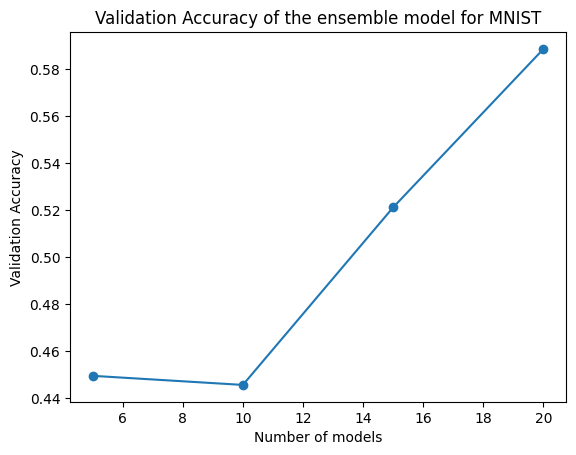

In [ ]:
# Testing for 5, 10, 15, and 20 number of models
plt.plot([5,10,15,20], model_for_plot, marker='o')
plt.xlabel("Number of models")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy of the ensemble model for MNIST")
plt.show()